In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os, glob, random, time, math
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import random

In [3]:
class ResNetFeatureExtractor(nn.Module):
    """
    Matches Table 2 of the Paper.
    Input: (B, 1, 48, 132) -> Output: (B, 512, 2, 32)
    """
    def __init__(self):
        super().__init__()
        # Conv1: 48x132 -> 48x132
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(True)
        )
        # Pool1: 48x132 -> 24x66
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv2: 24x66 -> 24x66
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(True)
        )
        # Pool2: 24x66 -> 12x33
        self.pool2 = nn.MaxPool2d(2, 2)

        # Conv3 + Conv4
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True)
        )
        # Pool3: 12x33 -> 6x33 (Pool Height Only)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))

        # Conv5 + Conv6
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True)
        )
        # Pool4: 6x33 -> 3x33 (Pool Height Only)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))

        # Conv7
        self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)

        # --- FIX 2: ADAPTIVE POOLING ---
        # The paper output is 2x32.
        # Conv7 outputs 3x33 (calculated from 48px input).
        # Instead of x[:,:,:2,:32] (cropping), we interpolate.
        self.final_pool = nn.AdaptiveAvgPool2d((2, 32))

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.conv4(self.conv3(x))
        x = self.pool3(x)
        x = self.conv6(self.conv5(x))
        x = self.pool4(x)
        x = self.conv7(x)

        # Resize to exactly 2x32 to match PatchEncoder expectations
        x = self.final_pool(x)
        return x

In [4]:
class PatchEncoder(nn.Module):
    def __init__(self, in_channels, emb_dim, k1=2, k2=1, max_patches=256):
        """
        Implements PATCHENC(k1, k2) from the paper.
        """
        super().__init__()

        self.k1 = k1
        self.k2 = k2

        # Linear projection via Conv2d (ViT-style)
        self.proj = nn.Conv2d(
            in_channels,
            emb_dim,
            kernel_size=(k1, k2),
            stride=(k1, k2)
        )

        # Local positional embedding (maximum length only)
        self.pos_emb = nn.Parameter(
            torch.zeros(max_patches, emb_dim)
        )
        nn.init.trunc_normal_(self.pos_emb, std=0.02)

    def forward(self, F):
        """
        F: (B, C, H', W')
        """
        x = self.proj(F)  # (B, D, H'/k1, W'/k2)

        B, D, Hp, Wp = x.shape
        N = Hp * Wp

        # Flatten spatial → sequence
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)

        # Add LOCAL positional embedding
        x = x + self.pos_emb[:N].unsqueeze(0)

        return x, N


In [5]:
# @title
def make_encoder(emb_dim=384, nhead=8, num_layers=3, dim_feedforward=1024, dropout=0.1):
    enc_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout, activation='relu')
    encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
    return encoder

In [6]:
# @title
import torch
import torch.nn as nn

# 1. Inherit from nn.Module
class Merger(nn.Module):
    def __init__(self, emb_dim, max_total_len=4096):
        # 2. Initialize the parent class (CRITICAL)
        super().__init__()

        # learned global pos emb for merged sequences up to max_total_len
        self.global_pos = nn.Parameter(torch.zeros(max_total_len, emb_dim))
        nn.init.trunc_normal_(self.global_pos, std=0.02)

    def merge_and_pad(self, enc_list):
        """
        enc_list: list of tensors (B,), where each tensor is (L_i, D)
        Returns:
          enc_batch: (B, Lmax, D)
          mask: (B, Lmax) Boolean (True=Padding)
        """
        # This will now work because enc_list is on GPU
        device = enc_list[0].device
        B = len(enc_list)
        D = enc_list[0].size(1)

        # 1. Calculate max length
        lengths = [t.size(0) for t in enc_list]
        Lmax = max(lengths)

        # 2. Prepare tensors
        enc_batch = torch.zeros(B, Lmax, D, device=device)
        mask = torch.ones(B, Lmax, dtype=torch.bool, device=device)

        # 3. Fill data
        for i, t in enumerate(enc_list):
            L_i = t.size(0)
            enc_batch[i, :L_i, :] = t
            mask[i, :L_i] = False

        # 4. Add global positional embeddings
        # Since this class is now an nn.Module, self.global_pos will
        # automatically move to GPU when you call model.cuda()
        enc_batch = enc_batch + self.global_pos[:Lmax, :].unsqueeze(0)

        return enc_batch, mask

In [7]:
# @title
class TransformerDecoderWrapper(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead=8, num_layers=3, pad_idx=0, max_len=256):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        dec_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=emb_dim*4, dropout=0.1)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)

        self.pos_emb = nn.Parameter(torch.zeros(max_len, emb_dim))
        nn.init.trunc_normal_(self.pos_emb, std=0.1)
        self.out_proj = nn.Linear(emb_dim, vocab_size)
        self.pad_idx = pad_idx

    def generate_square_subsequent_mask(self, sz):
        # Generates causal mask (Float: -inf for future, 0 for past)
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, tgt_tokens, memory, memory_key_padding_mask):
        B, T = tgt_tokens.size()
        device = tgt_tokens.device

        # 1. Embeddings
        tok = self.tok_emb(tgt_tokens)
        pos = self.pos_emb[:T,:].unsqueeze(0).expand(B,-1,-1)
        tgt = (tok + pos).transpose(0,1)

        # 2. Masks
        # [FIXED] Create Boolean Mask for Padding (True = Pad)
        tgt_key_padding_mask = (tgt_tokens == self.pad_idx)

        # [FIXED] Ensure memory mask is Boolean
        if memory_key_padding_mask is not None:
             # Ensure it's bool. If it was float/int 0/1, convert to bool
             memory_key_padding_mask = memory_key_padding_mask.bool()

        # Causal Mask (Float)
        tgt_mask = self.generate_square_subsequent_mask(T).to(device)

        mem = memory.transpose(0,1)

        # 3. Decoder Pass
        dec_out = self.decoder(
            tgt,
            mem,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,     # Pass BOOL here
            memory_key_padding_mask=memory_key_padding_mask # Pass BOOL here
        )

        logits = self.out_proj(dec_out.transpose(0,1))
        return logits

In [8]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

class KhmerOCR(nn.Module):
    def __init__(self, vocab_size, pad_idx=0, emb_dim=256, max_global_len=4096):
        super().__init__()

        # 1. Feature Extractor (CNN)
        self.cnn = ResNetFeatureExtractor()

        # 2. Patch Embedding (Local Position Embedding)
        # The paper mentions: "Position embedding... requires a maximum length... usually derived from training data."
        # This layer handles the LOCAL positions within a 132px chunk.
        self.patch = PatchEncoder(512, emb_dim=emb_dim, k1=2, k2=1)

        # 3. Local Encoder (TRENC - Transformer Encoder)
        # PAPER REQUIREMENT: "Features of each chunk are processed independently"
        # We use batch_first=False here to match standard PyTorch Transformer expectations if needed,
        # or handle transposition manually. Let's assume standard (Seq, Batch, Dim).
        self.enc = make_encoder(emb_dim=emb_dim, nhead=8, num_layers=2)

        # 4. Merger (Global Position Embedding)
        # Since chunks are processed independently, they don't know "I am Chunk 1" or "I am Chunk 5".
        # We MUST add global positional info after merging.
        self.global_pos = nn.Parameter(torch.zeros(max_global_len, emb_dim))
        nn.init.trunc_normal_(self.global_pos, std=0.02)

        # 5. Decoder
        self.dec = TransformerDecoderWrapper(vocab_size, emb_dim=emb_dim, nhead=8,
                                             num_layers=2, pad_idx=pad_idx)
        self.pad_idx = pad_idx

    def forward(self, chunk_lists, tgt_tokens):
        """
        chunk_lists: List of Lists of Tensors.
                     Img1: [C1, C2]
                     Img2: [C1, C2, C3]
        tgt_tokens: (B, L)
        """

        # 1. Flatten all chunks into one list
        # We store sizes to reconstruct the batch later
        chunk_sizes = [len(c) for c in chunk_lists]

        # OPTIMIZATION:
        # Since 'chunk_image' guarantees all chunks are 100px wide and 48px high,
        # we don't need a loop to pad them. We can just stack them.

        # Flatten the list of lists
        flat_input_list = [chunk for img_chunks in chunk_lists for chunk in img_chunks]

        # Stack directly (Fast!)
        # Shape: [Total_Chunks_In_Batch, 1, 48, 100]
        flat_input = torch.stack(flat_input_list)

        # 2. CNN
        f = self.cnn(flat_input)

        # 3. Patch Embedding + Local Positional Encoding
        p, _ = self.patch(f)

        # 4. Transformer Encoder (Runs on chunks individually!)
        # Transpose to [Seq_Len, Total_Chunks, Dim] for the encoder
        p = p.transpose(0, 1).contiguous()
        enc_out = self.enc(p)
        # Transpose back to [Total_Chunks, Seq_Len, Dim]
        enc_out = enc_out.transpose(0, 1)

        # 5. Merging (Stitching the sequence)
        batch_encoded_list = []
        cursor = 0
        feature_dim = enc_out.size(-1)

        # Split the flat tensor back into per-image sequences
        # This is fast because we are slicing a tensor, not a list
        for size in chunk_sizes:
            # img_chunks shape: [N_Chunks, Local_Seq_Len, Dim]
            img_chunks = enc_out[cursor : cursor + size]

            # Merge: [N_Chunks * Local_Seq_Len, Dim]
            merged_seq = img_chunks.reshape(-1, feature_dim)

            batch_encoded_list.append(merged_seq)
            cursor += size

        # 6. Pad to create a batch for the Decoder
        # memory: [Batch, Global_Seq_Len, Dim]
        memory = pad_sequence(batch_encoded_list, batch_first=True, padding_value=0.0)

        # 7. Global Positional Embedding
        B, T, _ = memory.shape
        # Safe slicing
        limit = min(T, self.global_pos.size(0))
        pos_emb = self.global_pos[:limit, :].unsqueeze(0)

        if T > self.global_pos.size(0):
             memory = memory[:, :limit, :] + pos_emb
             # We must also crop the memory mask if we cropped memory
             T = limit
        else:
             memory = memory + pos_emb

        # 8. Create Padding Mask
        memory_key_padding_mask = torch.ones((B, T), dtype=torch.bool, device=memory.device)

        for i, seq in enumerate(batch_encoded_list):
            valid_len = min(seq.shape[0], T) # Handle the rare cropping case
            memory_key_padding_mask[i, :valid_len] = False

        # 9. Decoder
        logits = self.dec(tgt_tokens, memory, memory_key_padding_mask)

        return logits

In [ ]:
# @title
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random

# ============================================================
# 1. FIXED AUGMENTER (Randomness moved to __call__)
# ============================================================

class ConsistentAugmenter:
    def __init__(self, augment_prob=0.8, is_low_res_input=True):
        self.augment_prob = augment_prob
        self.is_low_res = is_low_res_input
        self.pad_value = 1.0 # White background

    def __call__(self, img):
        # 1. Decide if we augment this specific image
        if random.random() > self.augment_prob:
            return img

        C, H, W = img.shape

        # --- Random Decisions (Must be calculated PER IMAGE) ---
        geom_mode = random.choice(['none', 'short', 'shrink'])
        scale_h = random.uniform(0.7, 0.98)
        scale_all = random.uniform(0.8, 0.98)

        do_pixelate = False
        if not self.is_low_res:
            do_pixelate = random.random() < 0.5

        do_blur = random.random() < 0.3
        blur_sigma = random.uniform(0.5, 1.0) if self.is_low_res else random.uniform(1.0, 2.0)

        do_noise = random.random() < 0.5
        noise_std = random.uniform(0.02, 0.08)

        do_shift = random.random() < 0.5
        shift_x = random.randint(-8, 8)

        do_erode = False
        if not self.is_low_res:
            do_erode = random.random() < 0.2

        # --- EXECUTE AUGMENTATIONS ---

        # 1. Geometry
        if geom_mode == 'short':
            new_h = int(H * scale_h)
            if new_h < H:
                resized = F.interpolate(img.unsqueeze(0), size=(new_h, W), mode='bilinear', align_corners=False).squeeze(0)
                background = torch.full_like(img, self.pad_value)
                pad_top = (H - new_h) // 2
                background[:, pad_top : pad_top + new_h, :] = resized
                img = background

        elif geom_mode == 'shrink':
            new_h = int(H * scale_all)
            new_w = int(W * scale_all)
            new_w = max(1, new_w)
            if new_h < H:
                resized = F.interpolate(img.unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False).squeeze(0)
                background = torch.full_like(img, self.pad_value)
                pad_top = (H - new_h) // 2
                pad_left = (W - new_w) // 2
                # Ensure dimensions match before assigning
                end_y = pad_top + new_h
                end_x = pad_left + new_w
                if end_y <= H and end_x <= W:
                    background[:, pad_top:end_y, pad_left:end_x] = resized
                    img = background

        # 2. Pixelate
        if do_pixelate:
            pixelate_scale = random.uniform(0.4, 0.7)
            small_h = int(H * pixelate_scale)
            small_w = int(W * pixelate_scale)
            small_h, small_w = max(16, small_h), max(4, small_w)
            small = F.interpolate(img.unsqueeze(0), size=(small_h, small_w), mode='bilinear', align_corners=False)
            img = F.interpolate(small, size=(H, W), mode='bilinear', align_corners=False).squeeze(0)

        # 3. Erosion (Thinning text on white background)
        if do_erode:
            erode_k = 3
            padding = erode_k // 2
            # Max pooling on (0=Black, 1=White) expands White -> Erodes Black text
            fully_eroded = F.max_pool2d(img, kernel_size=erode_k, stride=1, padding=padding)
            img = torch.lerp(img, fully_eroded, random.uniform(0.5, 0.8))

        # 4. Blur
        if do_blur:
            img = self.gaussian_blur(img, 3, blur_sigma)

        # 5. Noise
        if do_noise:
            noise = torch.randn_like(img) * noise_std
            img = torch.clamp(img + noise, 0.0, 1.0)

        # 6. Shift
        if do_shift and shift_x != 0:
            shifted = torch.full_like(img, self.pad_value)
            if shift_x > 0: # Shift Right
                if shift_x < W:
                    shifted[:, :, shift_x:] = img[:, :, :-shift_x]
            else: # Shift Left
                abs_x = abs(shift_x)
                if abs_x < W:
                    shifted[:, :, :-abs_x] = img[:, :, abs_x:]
            img = shifted

        return img

    def gaussian_blur(self, img, kernel_size, sigma):
        x = torch.arange(kernel_size, dtype=torch.float32, device=img.device) - kernel_size // 2
        kernel_1d = torch.exp(-x**2 / (2 * sigma**2))
        kernel_1d = kernel_1d / kernel_1d.sum()
        k_x = kernel_1d.view(1, 1, 1, kernel_size)
        k_y = kernel_1d.view(1, 1, kernel_size, 1)
        pad = kernel_size // 2
        img = F.conv2d(img.unsqueeze(0), k_x, padding=(0, pad), groups=img.shape[0])
        img = F.conv2d(img, k_y, padding=(pad, 0), groups=img.shape[0])
        return img.squeeze(0)

In [ ]:
# @title
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

# -----------------------------
# 1. Chunking helper
# -----------------------------
def chunk_image(img, chunk_width=100, overlap=16):
    """
    img: Tensor [C,H,W] (grayscale, normalized 0..1)
    Returns: List of chunks [C,H,chunk_width]
    """
    C, H, W = img.shape
    chunks = []
    start = 0

    while start < W:
        end = min(start + chunk_width, W)
        chunk = img[:, :, start:end]

        # Only pad last chunk if it's shorter than chunk_width
        if chunk.shape[2] < chunk_width:
            pad_size = chunk_width - chunk.shape[2]
            chunk = torch.nn.functional.pad(chunk, (0, pad_size), value=1.0)

        chunks.append(chunk)
        start += chunk_width - overlap

    return chunks

# ============================================================
# 3. DATASET (Fixed to USE the augmenter)
# ============================================================

class KhmerOCRDataset(Dataset):
    def __init__(self, hf_datasets, char2idx, augment=False, chunk_width=100, overlap=16):
        self.data = []
        for ds in hf_datasets:
            for example in ds:
                self.data.append({'image': example['image'], 'label': example['label']})

        self.char2idx = char2idx
        self.sos_idx = char2idx["<sos>"]
        self.eos_idx = char2idx["<eos>"]
        self.pad_idx = char2idx.get("<pad>", 0)

        self.augment = augment

        # --- INITIALIZE AUGMENTER ---
        if self.augment:
            self.augmenter = ConsistentAugmenter(augment_prob=0.8, is_low_res_input=True)
        # ----------------------------

        self.chunk_width = chunk_width
        self.overlap = overlap

        self.to_tensor = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor() # Output 0.0 to 1.0
        ])

        self.target_height = 48

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        pil_img = sample['image']

        # 1. Resize to 48px Height
        if pil_img.height != self.target_height:
            aspect_ratio = pil_img.width / pil_img.height
            new_width = int(self.target_height * aspect_ratio)
            pil_img = pil_img.resize((new_width, self.target_height), Image.Resampling.BILINEAR)

        # 2. Convert to Tensor [1, 48, W] (0.0 - 1.0 range)
        img = self.to_tensor(pil_img)

        # 3. --- APPLY AUGMENTATION ---
        if self.augment:
            img = self.augmenter(img)
        # -----------------------------

        # 4. Chunking
        chunks = chunk_image(img, self.chunk_width, self.overlap)

        # 5. Normalization (0.0-1.0 -> -1.0-1.0)
        # MUST happen AFTER augmentation, because augmenter expects 0-1 (white=1.0)
        chunks_t = [(c - 0.5)/0.5 for c in chunks]

        # 6. Label processing
        text = sample['label']
        label = [self.sos_idx] + [self.char2idx.get(ch, self.char2idx["<unk>"]) for ch in text] + [self.eos_idx]

        return chunks_t, torch.tensor(label, dtype=torch.long), text
# -----------------------------
# 3. Collate function for batching
# -----------------------------
def khmer_collate_fn(batch):
    """
    batch: list of tuples (chunks_list, label_tensor, text)
    Returns:
        - list of lists of chunks [batch_size, N_chunks, C,H,W]
        - padded labels tensor [batch_size, max_len]
        - list of text labels
    """
    chunk_lists, labels, texts = zip(*batch)

    # pad labels to max length
    max_len = max(len(l) for l in labels)
    label_pad = torch.full((len(labels), max_len), 0, dtype=torch.long)
    for i,l in enumerate(labels):
        label_pad[i, :len(l)] = l

    return list(chunk_lists), label_pad, list(texts)


In [9]:
# @title
import json

with open("/content/drive/MyDrive/CNN-Transformer-OCR/idx2char.json", "r", encoding="utf-8") as f:
    idx2char = {int(k): v for k, v in json.load(f).items()}

with open("/content/drive/MyDrive/CNN-Transformer-OCR/char2idx.json", "r", encoding="utf-8") as f:
    char2idx = json.load(f)

vocab_size = len(char2idx)
print("Vocab size:", vocab_size)

Vocab size: 124


In [ ]:
# @title
from datasets import load_dataset
from torch.utils.data import DataLoader

# -----------------------------
# 1. Load Hugging Face datasets
# -----------------------------
dataset_names = [
    "Darayut/khmer-scene-text-synthetic-contrast",
    "Darayut/khmer-document-synthetic-low-res",
    # "Darayut/khmer-scene-text-synthetic",
    # "Darayut/khmer-document-synthetic"
]

hf_datasets = []
for name in dataset_names:
    ds = load_dataset(name, split="train")  # or "all" if applicable
    hf_datasets.append(ds)

print("Datasets loaded:", [len(ds) for ds in hf_datasets])


# -----------------------------
# 3. Create dataset
# -----------------------------
train_dataset = KhmerOCRDataset(
    hf_datasets=hf_datasets,
    char2idx=char2idx,
    augment=True,
    chunk_width=100,  # as in paper
    overlap=16        # as in paper
)

# -----------------------------
# 4. Create DataLoader
# -----------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=32,       # number of images per batch
    shuffle=True,
    collate_fn=khmer_collate_fn,
    num_workers=4,       # adjust based on your machine
    pin_memory=True
)

# -----------------------------
# 5. Example iteration
# -----------------------------
for batch_idx, (chunk_lists, label_pad, texts) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print("Number of images in batch:", len(chunk_lists))
    print("Labels shape:", label_pad.shape)
    print("First image has", len(chunk_lists[0]), "chunks")
    break


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/323 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/102500 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/320 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Datasets loaded: [102500, 100000]
Batch 0
Number of images in batch: 32
Labels shape: torch.Size([32, 86])
First image has 6 chunks


--- Visualizing Data Pipeline ---
Original Text: គ្រប់៣២ ភ្លេងសុទ្ធ អត្រាប្តូរប្រាក់
Number of Chunks: 3
Shape of first chunk: torch.Size([1, 48, 100])
✅ Height is correct (48px).


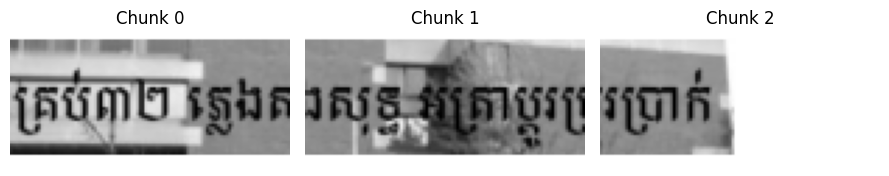

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch(dataset):
    # Get one sample
    chunks, label, text = dataset[4]

    print(f"Original Text: {text}")
    print(f"Number of Chunks: {len(chunks)}")
    print(f"Shape of first chunk: {chunks[0].shape}")

    # Check Height Constraint
    if chunks[0].shape[1] != 48:
        print(f"❌ CRITICAL ERROR: Chunk height is {chunks[0].shape[1]}, expected 48!")
    else:
        print(f"✅ Height is correct (48px).")

    # Plot chunks
    fig, axes = plt.subplots(1, len(chunks), figsize=(len(chunks)*3, 2))
    if len(chunks) == 1: axes = [axes]

    for i, chunk in enumerate(chunks):
        # Un-normalize: (val * 0.5) + 0.5 to get back to 0..1 range
        img = chunk.clone().detach().cpu().squeeze().numpy()
        img = (img * 0.5) + 0.5

        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f"Chunk {i}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Run it
# Assuming 'train_dataset' is already instantiated from your code
print("--- Visualizing Data Pipeline ---")
visualize_batch(train_dataset)

--- Verifying Padding ---
Original Text: បន្ទាយមានជ័យស្ថិតបុណ្យផ្កា ប៉ះ0:បំផុត ឯកឧត្ដមរដ្ឋមន្ត្រី
Number of Chunks: 5
Shape of first chunk: torch.Size([1, 48, 100])
✅ Numerical Check: The last column of the last chunk is pure WHITE (1.0). It is padded.


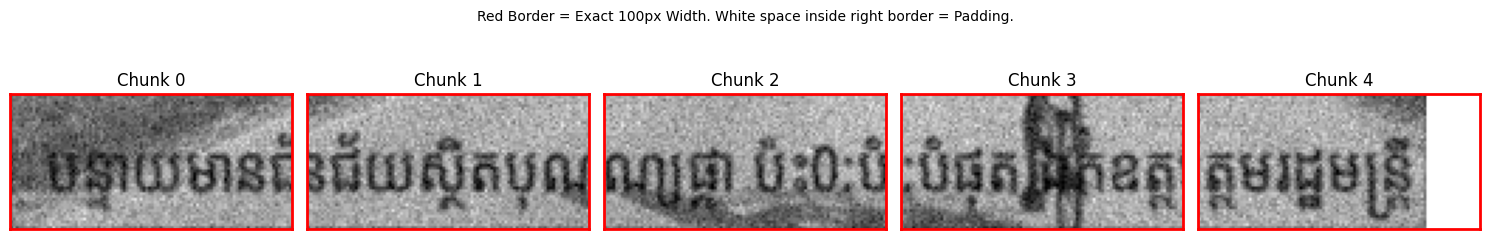

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_batch_with_padding_check(dataset, sample_idx=4):
    # Get the sample
    chunks, label, text = dataset[sample_idx]

    print(f"Original Text: {text}")
    print(f"Number of Chunks: {len(chunks)}")
    print(f"Shape of first chunk: {chunks[0].shape}") # Should be [1, 48, 100]

    # --- 1. NUMERICAL CHECK ---
    # Check the last column of pixels of the last chunk
    last_chunk = chunks[-1] # [1, 48, 100]

    # Since you normalized with (x-0.5)/0.5, White (1.0) becomes 1.0.
    # We check if the last column is all 1.0s (or close to it due to float precision)
    last_col = last_chunk[0, :, -1]
    is_padded_numerically = torch.allclose(last_col, torch.tensor(1.0), atol=1e-4)

    if is_padded_numerically:
        print("✅ Numerical Check: The last column of the last chunk is pure WHITE (1.0). It is padded.")
    else:
        print("ℹ️ Numerical Check: The last column contains data (not pure white). It might fit perfectly or not be padded.")

    # --- 2. VISUAL CHECK ---
    fig, axes = plt.subplots(1, len(chunks), figsize=(len(chunks)*3, 2.5))
    if len(chunks) == 1: axes = [axes]

    for i, chunk in enumerate(chunks):
        # Un-normalize: (val * 0.5) + 0.5 to get back to 0..1 range
        img = chunk.clone().detach().cpu().squeeze().numpy()
        img = (img * 0.5) + 0.5

        # Plot
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f"Chunk {i}")

        # Remove ticks but keep the box
        axes[i].set_xticks([])
        axes[i].set_yticks([])

        # Add a RED BORDER to show the exact 100px width
        for spine in axes[i].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)

    plt.suptitle(f"Red Border = Exact {dataset.chunk_width}px Width. White space inside right border = Padding.", fontsize=10, y=1.05)
    plt.tight_layout()
    plt.show()

# Run it
print("--- Verifying Padding ---")
# Try index 4 (or try index 0, 1 to find a short/end-of-line image)
visualize_batch_with_padding_check(train_dataset, sample_idx=6)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR
import random

# -----------------------------
# 1. Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2. Model Initialization
# -----------------------------
vocab_size = len(char2idx)
pad_idx = char2idx["<pad>"]
emb_dim = 384  # as in your transformer
max_global_len = 4096

model = KhmerOCR(vocab_size=vocab_size, pad_idx=pad_idx, emb_dim=emb_dim, max_global_len=max_global_len)
model.to(device)

# -----------------------------
# 3. Optimizer
# -----------------------------
optimizer = Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

# -----------------------------
# 4. Loss function
# -----------------------------
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# -----------------------------
# 5. Training Loop
# -----------------------------
num_epochs = 100
epoch_sample_size = 50_000  # select 100k random images per epoch
batch_size = 32



Using device: cuda


In [ ]:
# @title
def verify_architecture_flow(model, dataset, collate_fn, device):
    model.eval()

    # 1. Create a tiny batch (2 samples)
    batch = [dataset[0], dataset[1]]
    chunk_lists, label_pad, texts = collate_fn(batch)

    # Move to device
    label_pad = label_pad.to(device)
    chunk_lists = [[c.to(device) for c in img_chunks] for img_chunks in chunk_lists]

    print("\n--- Starting Architecture Flow Check ---")

    with torch.no_grad():
        # A. Flatten Inputs
        flat_input = torch.stack([c for sublist in chunk_lists for c in sublist])
        print(f"1. CNN Input Shape: {flat_input.shape}")
        # Expected: [Total_Chunks, 1, 48, 100]

        # B. CNN Pass
        f = model.cnn(flat_input)
        print(f"2. CNN Output Shape: {f.shape}")

        # VERIFICATION: Did AdaptivePool work?
        if f.shape[-2:] != (2, 32):
            print(f"❌ CNN Output wrong size! Got {f.shape[-2:]}, Expected (2, 32)")
            return
        else:
            print(f"✅ CNN Output spatial size is correct (2, 32).")

        # C. Patch Encoder
        p, _ = model.patch(f)
        print(f"3. PatchEncoder Output: {p.shape}")
        # Expected: [Batch, SeqLen, EmbDim]

        # D. Encoder Pass
        # Simulate the transpose logic
        p = p.transpose(0, 1)
        enc_out = model.enc(p)
        enc_out = enc_out.transpose(0, 1)
        print(f"4. Transformer Encoder Output: {enc_out.shape}")

        # E. Decoder Pass (Full Model)
        logits = model(chunk_lists, label_pad[:, :-1])
        print(f"5. Final Logits Shape: {logits.shape}")
        # Expected: [Batch_Size, Target_Seq_Len-1, Vocab_Size]

        print("✅ Data flowed through the whole model successfully!")

# Run it
verify_architecture_flow(model, train_dataset, khmer_collate_fn, device)


--- Starting Architecture Flow Check ---
1. CNN Input Shape: torch.Size([11, 1, 48, 100])
2. CNN Output Shape: torch.Size([11, 512, 2, 32])
✅ CNN Output spatial size is correct (2, 32).
3. PatchEncoder Output: torch.Size([11, 32, 384])
4. Transformer Encoder Output: torch.Size([11, 32, 384])
5. Final Logits Shape: torch.Size([2, 70, 124])
✅ Data flowed through the whole model successfully!


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
# @title
def sanity_check_overfit(model, dataset, collate_fn, device, iterations=50):
    print("\n--- Starting Overfit Sanity Check ---")

    # Take ONE batch of 4 images
    indices = [0, 1, 2, 3]
    subset = torch.utils.data.Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=4, collate_fn=collate_fn)

    # Get the fixed batch
    batch = next(iter(loader))
    chunk_lists, label_pad, _ = batch

    label_pad = label_pad.to(device)
    chunk_lists = [[c.to(device) for c in img_chunks] for img_chunks in chunk_lists]

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_idx)

    model.train()

    initial_loss = 0
    final_loss = 0

    for i in range(iterations):
        optimizer.zero_grad()

        logits = model(chunk_lists, label_pad[:, :-1])

        # Flatten for loss
        # logits: [B, T, Vocab] -> [B*T, Vocab]
        # targets: [B, T] -> [B*T]
        loss = criterion(logits.reshape(-1, logits.size(-1)), label_pad[:, 1:].reshape(-1))

        loss.backward()
        optimizer.step()

        if i == 0: initial_loss = loss.item()
        final_loss = loss.item()

        if i % 10 == 0:
            print(f"Iter {i}: Loss = {loss.item():.4f}")

    print(f"Start Loss: {initial_loss:.4f} -> End Loss: {final_loss:.4f}")

    if final_loss < initial_loss * 0.1:
        print("✅ SUCCESS: Model is learning! (Loss dropped significantly)")
    else:
        print("❌ FAILURE: Model is not converging on this small batch. Check Learning Rate or Architecture.")

# Run it
sanity_check_overfit(model, train_dataset, khmer_collate_fn, device)


--- Starting Overfit Sanity Check ---
Iter 0: Loss = 4.9764
Iter 10: Loss = 2.1125
Iter 20: Loss = 0.8859
Iter 30: Loss = 0.4149
Iter 40: Loss = 0.1785
Start Loss: 4.9764 -> End Loss: 0.0974
✅ SUCCESS: Model is learning! (Loss dropped significantly)


In [ ]:
for epoch in range(1, num_epochs+1):
    model.train()

    # --- 5a: Randomly sample 50K images for this epoch ---
    all_indices = list(range(len(train_dataset)))
    sampled_indices = random.sample(all_indices, epoch_sample_size)
    epoch_dataset = Subset(train_dataset, sampled_indices)

    # --- 5b: DataLoader ---
    train_loader = DataLoader(
        epoch_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=khmer_collate_fn,
        num_workers=4,
        pin_memory=True
    )

    # --- 5c: Adjust learning rate (cyclic schedule) ---
    if epoch <= 15:
        # initial LR 1e-4
        scheduler = None
    elif 16 <= epoch <= 30:
        scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-4, step_size_up=len(train_loader)//2, cycle_momentum=False)
    else:
        scheduler = CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-5, step_size_up=len(train_loader)//2, cycle_momentum=False)

    # --- 5d: Epoch training ---
    running_loss = 0.0
    for batch_idx, (chunk_lists, label_pad, _) in enumerate(train_loader):
        # Move data to device
        label_pad = label_pad.to(device)
        chunk_lists = [[c.to(device) for c in img_chunks] for img_chunks in chunk_lists]

        optimizer.zero_grad()
        logits = model(chunk_lists, label_pad[:, :-1])  # teacher forcing, ignore last token
        loss = criterion(logits.view(-1, vocab_size), label_pad[:, 1:].reshape(-1))  # shift by 1 for next-token prediction
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item()
        # LOGGING & DEBUGGING
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {running_loss/100:.4f}")
            running_loss = 0.0

            # ====================================================
            # ADD THIS: THE "EYE TEST"
            # ====================================================
            # Every 500 batches, verify what the model is actually predicting
            if (batch_idx + 1) % 500 == 0:
                model.eval() # Switch to eval mode
                with torch.no_grad():
                    # 1. Take the first sample from the current batch
                    # logits shape: [B, SeqLen, Vocab]
                    # We take index 0, and get the max probability for each token
                    pred_indices = torch.argmax(logits[0], dim=-1).cpu().numpy()

                    # 2. Get the Ground Truth
                    true_indices = label_pad[0, 1:].cpu().numpy() # Skip <sos>

                    # 3. Decode to Text
                    # Assuming 'idx2char' is available (reverse of char2idx)
                    idx2char = {v: k for k, v in char2idx.items()}

                    pred_text = "".join([idx2char.get(i, "") for i in pred_indices if i not in [char2idx["<pad>"], char2idx["<eos>"], char2idx["<sos>"]]])
                    true_text = "".join([idx2char.get(i, "") for i in true_indices if i not in [char2idx["<pad>"], char2idx["<eos>"], char2idx["<sos>"]]])

                    print("-" * 50)
                    print(f"SANITY CHECK (Epoch {epoch}):")
                    print(f"TRUE: {true_text}")
                    print(f"PRED: {pred_text}")
                    print("-" * 50)

                model.train() # Switch back to train mode immediately
            # ====================================================

    # Optional: save checkpoint every few epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch{epoch}.pth")
        print(f"Checkpoint saved at epoch {epoch}")


Epoch [1/100] Batch [100/1563] Loss: 3.6155
Epoch [1/100] Batch [200/1563] Loss: 3.1971
Epoch [1/100] Batch [300/1563] Loss: 3.1004
Epoch [1/100] Batch [400/1563] Loss: 3.0471
Epoch [1/100] Batch [500/1563] Loss: 3.0067
--------------------------------------------------
SANITY CHECK (Epoch 1):
TRUE: ខ្មែរមួយឈុតទំព័រដើម នោះខ្លឺត សាកលវិទ្យាល័យជនរងគ្រោះ ជំងឺបុរស
PRED: ក្លារប្យ ្ន្្ព្ត ្ម្ស្ះ ្ម ន៌ស្ន្្ិត្ម ន្ត ា្  ្រ ះ បាព្ន្ម ្្
--------------------------------------------------
Epoch [1/100] Batch [600/1563] Loss: 2.9569
Epoch [1/100] Batch [700/1563] Loss: 2.9128
Epoch [1/100] Batch [800/1563] Loss: 2.8617
Epoch [1/100] Batch [900/1563] Loss: 2.8152
Epoch [1/100] Batch [1000/1563] Loss: 2.7699
--------------------------------------------------
SANITY CHECK (Epoch 1):
TRUE: 3757 .ផ ឲ្យឈ្មោះថាដោះ ហង្សនាំភ្ញាក់ផ្អើល| មន្តអាគម
PRED: ប7   ស ្ស្យស្មោះ ្នោះ បា្គ្្រពានាព់ ្សាយ់ស្ាសែាយ្្
--------------------------------------------------
Epoch [1/100] Batch [1100/1563] Loss: 2.7229
Epoch [1/100

In [13]:
# @title
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import json
import math

# ==========================================
# 1. Helper Functions
# ==========================================

def chunk_image_inference(img_tensor, chunk_width=100, overlap=16):
    """
    Splits image into chunks. Matches training logic.
    """
    C, H, W = img_tensor.shape
    chunks = []
    start = 0

    while start < W:
        end = min(start + chunk_width, W)
        chunk = img_tensor[:, :, start:end]

        # Pad last chunk if shorter than chunk_width (Pad with 1.0 = White)
        if chunk.shape[2] < chunk_width:
            pad_size = chunk_width - chunk.shape[2]
            # F.pad: (left, right, top, bottom)
            chunk = F.pad(chunk, (0, pad_size, 0, 0), value=1.0)

        chunks.append(chunk)
        start += chunk_width - overlap

    return chunks

# ==========================================
# 2. Inference Class (Beam Search Enabled)
# ==========================================

class KhmerOCRInference:
    def __init__(self, model_path, char2idx_input, device='cuda'):
        """
        model_path: Path to .pt file
        char2idx_input: Dictionary OR Path to .json file
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # 1. Load Vocabulary
        if isinstance(char2idx_input, dict):
            self.char2idx = char2idx_input
        elif isinstance(char2idx_input, str):
            with open(char2idx_input, 'r', encoding='utf-8') as f:
                self.char2idx = json.load(f)
        else:
            raise ValueError("char2idx_input must be a dictionary or a json file path.")

        self.idx2char = {v: k for k, v in self.char2idx.items()}
        self.sos_idx = self.char2idx.get("<sos>")
        self.eos_idx = self.char2idx.get("<eos>")
        self.pad_idx = self.char2idx.get("<pad>", 0)

        if self.sos_idx is None or self.eos_idx is None:
            raise ValueError("Vocabulary must contain <sos> and <eos>")

        # 2. Initialize Model
        # Ensure these params match your training!
        self.model = KhmerOCR(
            vocab_size=len(self.char2idx),
            pad_idx=self.pad_idx,
            emb_dim=384,
            max_global_len=4096
        )

        # 3. Load Weights
        print(f"Loading weights from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint)
        self.model.to(self.device)
        self.model.eval()

        # 4. Transform
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(), # 0..1
        ])

    def preprocess(self, image_path):
        """
        Loads, RESIZES to Height 48, Chunks, and Normalizes.
        """
        # Load directly as Grayscale
        image = Image.open(image_path).convert('L')

        # --- CRITICAL FIX: RESIZE TO HEIGHT 48 ---
        target_height = 48
        aspect_ratio = image.width / image.height
        new_width = int(target_height * aspect_ratio)
        image = image.resize((new_width, target_height), Image.Resampling.BILINEAR)
        # -----------------------------------------

        img_tensor = self.transform(image) # [1, 48, W]

        # Chunking
        chunks = chunk_image_inference(img_tensor, chunk_width=100, overlap=16)

        # Normalization (Matches training: (x-0.5)/0.5)
        chunks_norm = [(c - 0.5) / 0.5 for c in chunks]

        # Stack to tensor [N_Chunks, 1, 48, 100]
        return torch.stack(chunks_norm).to(self.device)

    def encode_image(self, chunks_tensor):
        """
        Runs the CNN + Transformer Encoder + Merger + Global Pos
        Returns: memory [1, SeqLen, Dim]
        """
        # chunks_tensor: [N, 1, 48, 100]

        with torch.no_grad():
            # 1. CNN
            f = self.model.cnn(chunks_tensor) # [N, 512, 2, 32]

            # 2. Patch Embedding
            p, _ = self.model.patch(f) # [N, 32, 384]

            # 3. Transformer Encoder (Independent Chunks)
            # Input: [Seq, Batch, Dim]
            p = p.transpose(0, 1).contiguous()
            enc_out = self.model.enc(p)
            enc_out = enc_out.transpose(0, 1) # [N, 32, 384]

            # 4. Merger (Flatten N chunks into 1 sequence)
            # enc_out: [N, 32, Dim] -> [1, N*32, Dim]
            N, L, D = enc_out.shape
            merged_seq = enc_out.reshape(1, N * L, D)
            memory = merged_seq

            # 5. Global Positional Embedding
            B, T, _ = memory.shape
            limit = min(T, self.model.global_pos.size(0))
            pos_emb = self.model.global_pos[:limit, :].unsqueeze(0)

            if T > self.model.global_pos.size(0):
                 memory = memory[:, :limit, :] + pos_emb
            else:
                 memory = memory + pos_emb

            return memory

    def predict(self, image_path, max_len=128, beam_width=3):
        """
        Main inference method.
        beam_width=1 -> Greedy Search
        beam_width>1 -> Beam Search
        """
        # 1. Preprocess
        chunks_tensor = self.preprocess(image_path)

        # 2. Encode (Once)
        memory = self.encode_image(chunks_tensor)

        # 3. Decode
        if beam_width <= 1:
            tokens = self._greedy_decode(memory, max_len)
        else:
            tokens = self._beam_search(memory, max_len, beam_width)

        # 4. Detokenize
        result_text = ""
        for idx in tokens:
            if idx == self.sos_idx or idx == self.pad_idx:
                continue
            if idx == self.eos_idx:
                break
            char = self.idx2char.get(idx, "")
            result_text += char

        return result_text

    def _greedy_decode(self, memory, max_len):
        B, T, _ = memory.shape
        # Mask is all False (valid) because inference has no padding
        memory_mask = torch.zeros((B, T), dtype=torch.bool, device=self.device)

        generated = [self.sos_idx]

        with torch.no_grad():
            for _ in range(max_len):
                tgt = torch.LongTensor([generated]).to(self.device)
                logits = self.model.dec(tgt, memory, memory_mask)
                next_token = torch.argmax(logits[0, -1, :]).item()

                if next_token == self.eos_idx:
                    break
                generated.append(next_token)
        return generated

    def _beam_search(self, memory, max_len, beam_width):
        """
        Batched Beam Search Implementation
        """
        B, T, D = memory.shape

        # 1. Expand Memory to match beam width
        # memory: [1, T, D] -> [K, T, D]
        memory = memory.expand(beam_width, -1, -1)
        memory_mask = torch.zeros((beam_width, T), dtype=torch.bool, device=self.device)

        # 2. Initialize Beams
        # Format: (score, [sequence])
        # We start with 1 beam, but we treat it as K identical ones initially to simplify batching
        # or just run 1 item in the first step. Let's do standard expansion.
        beams = [(0.0, [self.sos_idx])]

        completed_beams = []

        with torch.no_grad():
            for step in range(max_len):
                # Prepare batch of inputs
                # Filter out finished beams? No, we filter at the end of the step.
                k_curr = len(beams)

                # Construct input tensor [k_curr, SeqLen]
                # We need to pad sequences if they differ in length (unlikely in standard beam search, but good practice)
                # Here they are always same length per step.
                current_seqs = [b[1] for b in beams]
                tgt = torch.tensor(current_seqs, dtype=torch.long, device=self.device)

                # Run Decoder on batch
                # Use slice of memory corresponding to k_curr
                step_logits = self.model.dec(tgt, memory[:k_curr], memory_mask[:k_curr])

                # Get Log Probs of the last token
                # shape: [k_curr, Vocab]
                last_token_logits = step_logits[:, -1, :]
                log_probs = F.log_softmax(last_token_logits, dim=-1)

                # Generate Candidates
                candidates = []
                for i in range(k_curr):
                    score_so_far = beams[i][0]
                    seq_so_far = beams[i][1]

                    # Optimization: Only consider top K tokens to reduce sorting overhead
                    topk_probs, topk_idx = log_probs[i].topk(beam_width)

                    for k in range(beam_width):
                        token = topk_idx[k].item()
                        prob = topk_probs[k].item()

                        new_score = score_so_far + prob
                        new_seq = seq_so_far + [token]
                        candidates.append((new_score, new_seq))

                # Sort and Select Top K
                candidates.sort(key=lambda x: x[0], reverse=True)

                next_beams = []
                for score, seq in candidates:
                    if seq[-1] == self.eos_idx:
                        # Normalize score by length to be fair
                        norm_score = score / (len(seq) - 1)
                        completed_beams.append((norm_score, seq))
                    else:
                        next_beams.append((score, seq))
                        if len(next_beams) == beam_width:
                            break

                beams = next_beams

                # Stop if no active beams left
                if not beams:
                    break

        # Final Selection
        if completed_beams:
            completed_beams.sort(key=lambda x: x[0], reverse=True)
            return completed_beams[0][1]
        elif beams:
            return beams[0][1] # Return best partial
        else:
            return [self.sos_idx]

# ==========================================
# 3. Usage Example
# ==========================================

if __name__ == "__main__":
    # 1. Settings
    MODEL_FILE = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch70.pth" # Update epoch

    # Assuming 'char2idx' dictionary exists in your notebook variables
    # If not, load it from a file
    VOCAB_DATA = char2idx

    IMAGE_FILE = "/content/task-1_goc_1_000_ពររជណចករកមពជ.png"

    try:
        # 2. Init
        ocr = KhmerOCRInference(MODEL_FILE, VOCAB_DATA)

        print(f"Processing: {IMAGE_FILE}")

        # 3. Predict with Beam Search (Width 3 or 5 is standard)
        text = ocr.predict(IMAGE_FILE, beam_width=5)

        print("\n" + "="*30)
        print(f"RESULT: {text}")
        print("="*30 + "\n")

    except FileNotFoundError:
        print("Error: Check your model or image path.")
    except Exception as e:
        import traceback
        traceback.print_exc()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch70.pth...
Processing: /content/task-1_goc_1_000_ពររជណចករកមពជ.png
Error: Check your model or image path.


In [ ]:
# @title
import os
import glob
import torch
import tqdm
import json
from PIL import Image

# ==========================================
# 0. Levenshtein Distance for CER
# ==========================================
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def calculate_cer(reference, hypothesis):
    if len(reference) == 0:
        return 1.0 if len(hypothesis) > 0 else 0.0
    dist = levenshtein_distance(reference, hypothesis)
    return dist / len(reference)

# ==========================================
# 1. Evaluation Class (Updated)
# ==========================================

class Evaluator:
    def __init__(self, inference_engine, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        self.engine = inference_engine
        self.extensions = valid_extensions

    def evaluate_split(self, root_folder, subset_name="default", beam_width=5, limit=None):
        """
        root_folder: The folder containing 'images' and 'labels' (e.g. test_set/khob_eval)
        subset_name: Name used for logging/saving files (e.g. "khob_eval")
        """

        print(f"\n🔵 Starting Evaluation for: {subset_name}")
        print(f"   Path: {root_folder}")

        # 1. Define Subpaths
        img_dir = os.path.join(root_folder, "images")
        lbl_dir = os.path.join(root_folder, "labels")

        # Verify paths exist
        if not os.path.exists(img_dir):
            print(f"❌ Error: 'images' folder not found at {img_dir}")
            return
        if not os.path.exists(lbl_dir):
            print(f"❌ Error: 'labels' folder not found at {lbl_dir}")
            return

        # 2. Find all images
        files = sorted(os.listdir(img_dir))
        image_files = [f for f in files if f.lower().endswith(self.extensions)]

        if len(image_files) == 0:
            print(f"❌ No images found in {img_dir}")
            return

        print(f"   Found {len(image_files)} images.")
        if limit:
            image_files = image_files[:limit]
            print(f"   Limiting evaluation to first {limit} images.")

        # 3. Metrics Setup
        total_cer = 0.0
        total_exact_match = 0
        total_samples = 0
        failures = []

        # 4. Evaluation Loop
        pbar = tqdm.tqdm(image_files, desc=f"Eval {subset_name}")

        for img_file in pbar:
            # Construct paths
            base_name = os.path.splitext(img_file)[0]

            # Try finding .txt label
            txt_file = base_name + ".txt"
            img_full_path = os.path.join(img_dir, img_file)
            txt_full_path = os.path.join(lbl_dir, txt_file)

            # Check if matching label exists
            if not os.path.exists(txt_full_path):
                continue

            # Load Ground Truth
            with open(txt_full_path, 'r', encoding='utf-8') as f:
                true_text = f.read().strip()

            # Predict
            try:
                pred_text = self.engine.predict(img_full_path, beam_width=beam_width)
            except Exception as e:
                print(f"Error predicting {img_file}: {e}")
                pred_text = ""

            # Calculate Stats
            cer = calculate_cer(true_text, pred_text)

            total_cer += cer
            if pred_text == true_text:
                total_exact_match += 1
            else:
                failures.append((img_file, pred_text, true_text, cer))

            total_samples += 1

            # Update Progress Bar
            current_avg_cer = total_cer / total_samples
            pbar.set_postfix({'CER': f'{current_avg_cer:.4f}'})

        # 5. Summary Report
        if total_samples == 0:
            print(f"   ⚠️ No valid image-label pairs found for {subset_name}.")
            return

        avg_cer = total_cer / total_samples
        accuracy = (total_exact_match / total_samples) * 100

        print("\n" + "-"*40)
        print(f"RESULTS: {subset_name} (Beam={beam_width})")
        print("-"*40)
        print(f"Total Images: {total_samples}")
        print(f"Accuracy:     {accuracy:.2f}%")
        print(f"Average CER:  {avg_cer:.4f}")
        print("-"*40)

        # 6. Save Failures with subset name in filename
        failure_path = f"evaluation_failures_{subset_name}.txt"
        with open(failure_path, "w", encoding="utf-8") as f:
            f.write(f"Evaluation Failures for {subset_name}\n")
            f.write(f"Avg CER: {avg_cer:.4f}\n\n")
            for fname, pred, true, err in failures:
                f.write(f"File: {fname}\n")
                f.write(f"True: {true}\n")
                f.write(f"Pred: {pred}\n")
                f.write(f"CER:  {err:.4f}\n")
                f.write("-" * 20 + "\n")

        print(f"📄 Failure report saved to {failure_path}")

# ==========================================
# 2. Run Evaluation
# ==========================================

if __name__ == "__main__":
    # Settings
    # Update this path to where your model is located
    MODEL_PATH = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth"

    # Ensure 'char2idx' is defined in your environment/notebook before running this
    # VOCAB_DATA = char2idx

    # Path to the ROOT test_set folder
    TEST_SET_ROOT = "/content/drive/MyDrive/CNN-Transformer-OCR/test_set"

    # The subfolders to process
    SUBSETS = ["legal_documents"]

    try:
        # 1. Init Inference Engine
        # Note: Ensure KhmerOCRInference is defined or imported
        ocr_engine = KhmerOCRInference(MODEL_PATH, VOCAB_DATA)

        # 2. Init Evaluator
        evaluator = Evaluator(ocr_engine)

        # 3. Loop through subfolders
        print(f"🚀 Starting Batch Evaluation on: {TEST_SET_ROOT}")

        for subset in SUBSETS:
            # Construct path: ./test_set/khob_eval
            subset_path = os.path.join(TEST_SET_ROOT, subset)

            # Check if directory exists before running
            if os.path.isdir(subset_path):
                evaluator.evaluate_split(subset_path, subset_name=subset, beam_width=3, limit=1000)
            else:
                print(f"⚠️ Warning: Folder not found: {subset_path}")

    except FileNotFoundError as e:
        print(f"File Error: {e}")
    except NameError as e:
        print(f"Code Error: {e}")
        print("Hint: Make sure 'KhmerOCRInference' class and 'char2idx' are defined.")

Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch70.pth...
🚀 Starting Batch Evaluation on: /content/drive/MyDrive/CNN-Transformer-OCR/test_set

🔵 Starting Evaluation for: khob_eval
   Path: /content/drive/MyDrive/CNN-Transformer-OCR/test_set/khob_eval
   Found 325 images.
   Limiting evaluation to first 1000 images.


Eval khob_eval:   0%|          | 0/325 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Eval khob_eval: 100%|██████████| 325/325 [06:06<00:00,  1.13s/it, CER=0.0526]



----------------------------------------
RESULTS: khob_eval (Beam=3)
----------------------------------------
Total Images: 325
Accuracy:     58.15%
Average CER:  0.0526
----------------------------------------
📄 Failure report saved to evaluation_failures_khob_eval.txt

🔵 Starting Evaluation for: printed_eval
   Path: /content/drive/MyDrive/CNN-Transformer-OCR/test_set/printed_eval
   Found 5000 images.
   Limiting evaluation to first 1000 images.


Eval printed_eval: 100%|██████████| 1000/1000 [19:49<00:00,  1.19s/it, CER=0.0361]


----------------------------------------
RESULTS: printed_eval (Beam=3)
----------------------------------------
Total Images: 1000
Accuracy:     72.90%
Average CER:  0.0361
----------------------------------------
📄 Failure report saved to evaluation_failures_printed_eval.txt


In [10]:
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Re-defining the class with Binarization added
class KhmerOCRInference:
    def __init__(self, model_path, char2idx_input, device='cuda', binarize=False):
        """
        binarize: If True, applies Otsu's binarization to inputs
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.binarize = binarize # <--- NEW FLAG

        # 1. Load Vocabulary
        if isinstance(char2idx_input, dict):
            self.char2idx = char2idx_input
        elif isinstance(char2idx_input, str):
            with open(char2idx_input, 'r', encoding='utf-8') as f:
                self.char2idx = json.load(f)
        else:
            raise ValueError("char2idx_input must be a dictionary or a json file path.")

        self.idx2char = {v: k for k, v in self.char2idx.items()}
        self.sos_idx = self.char2idx.get("<sos>")
        self.eos_idx = self.char2idx.get("<eos>")
        self.pad_idx = self.char2idx.get("<pad>", 0)

        # 2. Initialize Model (Ensure params match training)
        self.model = KhmerOCR(
            vocab_size=len(self.char2idx),
            pad_idx=self.pad_idx,
            emb_dim=384,
            max_global_len=4096
        )

        # 3. Load Weights
        print(f"Loading weights from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint)
        self.model.to(self.device)
        self.model.eval()

        # 4. Transform
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])

    def apply_binarization(self, image_path):
        """
        Reads image using OpenCV, applies Otsu's Binarization,
        and converts back to PIL.
        """
        # Read as grayscale
        img_cv = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img_cv is None:
            # Fallback if cv2 fails to read
            return Image.open(image_path).convert('L')

        # Apply Gaussian Blur to reduce noise before thresholding
        blur = cv2.GaussianBlur(img_cv, (5, 5), 0)

        # Otsu's Thresholding
        # Values < threshold become 0 (black), others become 255 (white)
        _, img_bin = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Convert back to PIL Image
        return Image.fromarray(img_bin)

    def preprocess(self, image_path):
        # --- MODIFIED LOADING LOGIC ---
        if self.binarize:
            image = self.apply_binarization(image_path)
        else:
            image = Image.open(image_path).convert('L')
        # ------------------------------

        # Resize to Height 48
        target_height = 48
        aspect_ratio = image.width / image.height
        new_width = int(target_height * aspect_ratio)
        image = image.resize((new_width, target_height), Image.Resampling.BILINEAR)

        img_tensor = self.transform(image)

        # Chunking
        chunks = chunk_image_inference(img_tensor, chunk_width=100, overlap=16)
        chunks_norm = [(c - 0.5) / 0.5 for c in chunks]

        return torch.stack(chunks_norm).to(self.device)

    def encode_image(self, chunks_tensor):
        # (Same as before)
        with torch.no_grad():
            f = self.model.cnn(chunks_tensor)
            p, _ = self.model.patch(f)
            p = p.transpose(0, 1).contiguous()
            enc_out = self.model.enc(p)
            enc_out = enc_out.transpose(0, 1)
            N, L, D = enc_out.shape
            merged_seq = enc_out.reshape(1, N * L, D)
            memory = merged_seq
            B, T, _ = memory.shape
            limit = min(T, self.model.global_pos.size(0))
            pos_emb = self.model.global_pos[:limit, :].unsqueeze(0)
            if T > self.model.global_pos.size(0):
                 memory = memory[:, :limit, :] + pos_emb
            else:
                 memory = memory + pos_emb
            return memory

    def predict(self, image_path, max_len=128, beam_width=3):
        chunks_tensor = self.preprocess(image_path)
        memory = self.encode_image(chunks_tensor)
        if beam_width <= 1:
            tokens = self._greedy_decode(memory, max_len)
        else:
            tokens = self._beam_search(memory, max_len, beam_width)

        result_text = ""
        for idx in tokens:
            if idx == self.sos_idx or idx == self.pad_idx: continue
            if idx == self.eos_idx: break
            result_text += self.idx2char.get(idx, "")
        return result_text

    def _greedy_decode(self, memory, max_len):
        # (Same as before)
        B, T, _ = memory.shape
        memory_mask = torch.zeros((B, T), dtype=torch.bool, device=self.device)
        generated = [self.sos_idx]
        with torch.no_grad():
            for _ in range(max_len):
                tgt = torch.LongTensor([generated]).to(self.device)
                logits = self.model.dec(tgt, memory, memory_mask)
                next_token = torch.argmax(logits[0, -1, :]).item()
                if next_token == self.eos_idx: break
                generated.append(next_token)
        return generated

    def _beam_search(self, memory, max_len, beam_width):
        # (Same as before - abbreviated for space)
        B, T, D = memory.shape
        memory = memory.expand(beam_width, -1, -1)
        memory_mask = torch.zeros((beam_width, T), dtype=torch.bool, device=self.device)
        beams = [(0.0, [self.sos_idx])]
        completed_beams = []
        with torch.no_grad():
            for step in range(max_len):
                k_curr = len(beams)
                current_seqs = [b[1] for b in beams]
                tgt = torch.tensor(current_seqs, dtype=torch.long, device=self.device)
                step_logits = self.model.dec(tgt, memory[:k_curr], memory_mask[:k_curr])
                log_probs = F.log_softmax(step_logits[:, -1, :], dim=-1)
                candidates = []
                for i in range(k_curr):
                    score_so_far = beams[i][0]
                    seq_so_far = beams[i][1]
                    topk_probs, topk_idx = log_probs[i].topk(beam_width)
                    for k in range(beam_width):
                        candidates.append((score_so_far + topk_probs[k].item(), seq_so_far + [topk_idx[k].item()]))
                candidates.sort(key=lambda x: x[0], reverse=True)
                next_beams = []
                for score, seq in candidates:
                    if seq[-1] == self.eos_idx:
                        completed_beams.append((score / (len(seq) - 1), seq))
                    else:
                        next_beams.append((score, seq))
                        if len(next_beams) == beam_width: break
                beams = next_beams
                if not beams: break
        if completed_beams:
            completed_beams.sort(key=lambda x: x[0], reverse=True)
            return completed_beams[0][1]
        elif beams:
            return beams[0][1]
        else:
            return [self.sos_idx]

In [32]:
# @title
import os
import glob
import torch
import tqdm
import json
from PIL import Image

# ==========================================
# 0. Levenshtein Distance for CER
# ==========================================
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def calculate_cer(reference, hypothesis):
    if len(reference) == 0:
        return 1.0 if len(hypothesis) > 0 else 0.0
    dist = levenshtein_distance(reference, hypothesis)
    return dist / len(reference)

# ==========================================
# 1. Evaluation Class (Updated)
# ==========================================

class Evaluator:
    def __init__(self, inference_engine, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        self.engine = inference_engine
        self.extensions = valid_extensions

    def evaluate_split(self, root_folder, subset_name="default", beam_width=5, limit=None):
        """
        root_folder: The folder containing 'images' and 'labels' (e.g. test_set/khob_eval)
        subset_name: Name used for logging/saving files (e.g. "khob_eval")
        """

        print(f"\n🔵 Starting Evaluation for: {subset_name}")
        print(f"   Path: {root_folder}")

        # 1. Define Subpaths
        img_dir = os.path.join(root_folder, "images")
        lbl_dir = os.path.join(root_folder, "labels")

        # Verify paths exist
        if not os.path.exists(img_dir):
            print(f"❌ Error: 'images' folder not found at {img_dir}")
            return
        if not os.path.exists(lbl_dir):
            print(f"❌ Error: 'labels' folder not found at {lbl_dir}")
            return

        # 2. Find all images
        files = sorted(os.listdir(img_dir))
        image_files = [f for f in files if f.lower().endswith(self.extensions)]

        if len(image_files) == 0:
            print(f"❌ No images found in {img_dir}")
            return

        print(f"   Found {len(image_files)} images.")
        if limit:
            image_files = image_files[:limit]
            print(f"   Limiting evaluation to first {limit} images.")

        # 3. Metrics Setup
        total_cer = 0.0
        total_exact_match = 0
        total_samples = 0
        failures = []

        # 4. Evaluation Loop
        pbar = tqdm.tqdm(image_files, desc=f"Eval {subset_name}")

        for img_file in pbar:
            # Construct paths
            base_name = os.path.splitext(img_file)[0]

            # Try finding .txt label
            txt_file = base_name + ".txt"
            img_full_path = os.path.join(img_dir, img_file)
            txt_full_path = os.path.join(lbl_dir, txt_file)

            # Check if matching label exists
            if not os.path.exists(txt_full_path):
                continue

            # Load Ground Truth
            with open(txt_full_path, 'r', encoding='utf-8') as f:
                true_text = f.read().strip()

            # Predict
            try:
                pred_text = self.engine.predict(img_full_path, beam_width=beam_width)
            except Exception as e:
                print(f"Error predicting {img_file}: {e}")
                pred_text = ""

            # Calculate Stats
            cer = calculate_cer(true_text, pred_text)

            total_cer += cer
            if pred_text == true_text:
                total_exact_match += 1
            else:
                failures.append((img_file, pred_text, true_text, cer))

            total_samples += 1

            # Update Progress Bar
            current_avg_cer = total_cer / total_samples
            pbar.set_postfix({'CER': f'{current_avg_cer:.4f}'})

        # 5. Summary Report
        if total_samples == 0:
            print(f"   ⚠️ No valid image-label pairs found for {subset_name}.")
            return

        avg_cer = total_cer / total_samples
        accuracy = (total_exact_match / total_samples) * 100

        print("\n" + "-"*40)
        print(f"RESULTS: {subset_name} (Beam={beam_width})")
        print("-"*40)
        print(f"Total Images: {total_samples}")
        print(f"Accuracy:     {accuracy:.2f}%")
        print(f"Average CER:  {avg_cer:.4f}")
        print("-"*40)

        # 6. Save Failures with subset name in filename
        failure_path = f"evaluation_failures_{subset_name}.txt"
        with open(failure_path, "w", encoding="utf-8") as f:
            f.write(f"Evaluation Failures for {subset_name}\n")
            f.write(f"Avg CER: {avg_cer:.4f}\n\n")
            for fname, pred, true, err in failures:
                f.write(f"File: {fname}\n")
                f.write(f"True: {true}\n")
                f.write(f"Pred: {pred}\n")
                f.write(f"CER:  {err:.4f}\n")
                f.write("-" * 20 + "\n")

        print(f"📄 Failure report saved to {failure_path}")

# ==========================================
# 2. Run Evaluation
# ==========================================

if __name__ == "__main__":
    # Settings
    # Update this path to where your model is located
    MODEL_PATH = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth"

    # Ensure 'char2idx' is defined in your environment/notebook before running this
    # VOCAB_DATA = char2idx

    # Path to the ROOT test_set folder
    TEST_SET_ROOT = "/content/drive/MyDrive/CNN-Transformer-OCR/test_set"

    # The subfolders to process
    SUBSETS = ["legal_documents"]

    try:
        # 1. Init Inference Engine
        # Note: Ensure KhmerOCRInference is defined or imported
        ocr_engine = KhmerOCRInference(MODEL_PATH, VOCAB_DATA)

        # 2. Init Evaluator
        evaluator = Evaluator(ocr_engine)

        # 3. Loop through subfolders
        print(f"🚀 Starting Batch Evaluation on: {TEST_SET_ROOT}")

        for subset in SUBSETS:
            # Construct path: ./test_set/khob_eval
            subset_path = os.path.join(TEST_SET_ROOT, subset)

            # Check if directory exists before running
            if os.path.isdir(subset_path):
                evaluator.evaluate_split(subset_path, subset_name=subset, beam_width=3, limit=1000)
            else:
                print(f"⚠️ Warning: Folder not found: {subset_path}")

    except FileNotFoundError as e:
        print(f"File Error: {e}")
    except NameError as e:
        print(f"Code Error: {e}")
        print("Hint: Make sure 'KhmerOCRInference' class and 'char2idx' are defined.")

Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth...
🚀 Starting Batch Evaluation on: /content/drive/MyDrive/CNN-Transformer-OCR/test_set

🔵 Starting Evaluation for: legal_documents
   Path: /content/drive/MyDrive/CNN-Transformer-OCR/test_set/legal_documents
   Found 220 images.
   Limiting evaluation to first 1000 images.


Eval legal_documents: 100%|██████████| 220/220 [02:55<00:00,  1.26it/s, CER=0.1027]


----------------------------------------
RESULTS: legal_documents (Beam=3)
----------------------------------------
Total Images: 220
Accuracy:     58.18%
Average CER:  0.1027
----------------------------------------
📄 Failure report saved to evaluation_failures_legal_documents.txt


In [ ]:
# @title
import os
import glob
import torch
import tqdm
import json
from PIL import Image

# ==========================================
# 0. Levenshtein Distance for CER
# ==========================================
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def calculate_cer(reference, hypothesis):
    if len(reference) == 0:
        return 1.0 if len(hypothesis) > 0 else 0.0
    dist = levenshtein_distance(reference, hypothesis)
    return dist / len(reference)

# ==========================================
# 1. Evaluation Class (Updated)
# ==========================================

class Evaluator:
    def __init__(self, inference_engine, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        self.engine = inference_engine
        self.extensions = valid_extensions

    def evaluate_split(self, root_folder, subset_name="default", beam_width=5, limit=None):
        """
        root_folder: The folder containing 'images' and 'labels' (e.g. test_set/khob_eval)
        subset_name: Name used for logging/saving files (e.g. "khob_eval")
        """

        print(f"\n🔵 Starting Evaluation for: {subset_name}")
        print(f"   Path: {root_folder}")

        # 1. Define Subpaths
        img_dir = os.path.join(root_folder, "images")
        lbl_dir = os.path.join(root_folder, "labels")

        # Verify paths exist
        if not os.path.exists(img_dir):
            print(f"❌ Error: 'images' folder not found at {img_dir}")
            return
        if not os.path.exists(lbl_dir):
            print(f"❌ Error: 'labels' folder not found at {lbl_dir}")
            return

        # 2. Find all images
        files = sorted(os.listdir(img_dir))
        image_files = [f for f in files if f.lower().endswith(self.extensions)]

        if len(image_files) == 0:
            print(f"❌ No images found in {img_dir}")
            return

        print(f"   Found {len(image_files)} images.")
        if limit:
            image_files = image_files[:limit]
            print(f"   Limiting evaluation to first {limit} images.")

        # 3. Metrics Setup
        total_cer = 0.0
        total_exact_match = 0
        total_samples = 0
        failures = []

        # 4. Evaluation Loop
        pbar = tqdm.tqdm(image_files, desc=f"Eval {subset_name}")

        for img_file in pbar:
            # Construct paths
            base_name = os.path.splitext(img_file)[0]

            # Try finding .txt label
            txt_file = base_name + ".txt"
            img_full_path = os.path.join(img_dir, img_file)
            txt_full_path = os.path.join(lbl_dir, txt_file)

            # Check if matching label exists
            if not os.path.exists(txt_full_path):
                continue

            # Load Ground Truth
            with open(txt_full_path, 'r', encoding='utf-8') as f:
                true_text = f.read().strip()

            # Predict
            try:
                pred_text = self.engine.predict(img_full_path, beam_width=beam_width)
            except Exception as e:
                print(f"Error predicting {img_file}: {e}")
                pred_text = ""

            # Calculate Stats
            cer = calculate_cer(true_text, pred_text)

            total_cer += cer
            if pred_text == true_text:
                total_exact_match += 1
            else:
                failures.append((img_file, pred_text, true_text, cer))

            total_samples += 1

            # Update Progress Bar
            current_avg_cer = total_cer / total_samples
            pbar.set_postfix({'CER': f'{current_avg_cer:.4f}'})

        # 5. Summary Report
        if total_samples == 0:
            print(f"   ⚠️ No valid image-label pairs found for {subset_name}.")
            return

        avg_cer = total_cer / total_samples
        accuracy = (total_exact_match / total_samples) * 100

        print("\n" + "-"*40)
        print(f"RESULTS: {subset_name} (Beam={beam_width})")
        print("-"*40)
        print(f"Total Images: {total_samples}")
        print(f"Accuracy:     {accuracy:.2f}%")
        print(f"Average CER:  {avg_cer:.4f}")
        print("-"*40)

        # 6. Save Failures with subset name in filename
        failure_path = f"evaluation_failures_{subset_name}.txt"
        with open(failure_path, "w", encoding="utf-8") as f:
            f.write(f"Evaluation Failures for {subset_name}\n")
            f.write(f"Avg CER: {avg_cer:.4f}\n\n")
            for fname, pred, true, err in failures:
                f.write(f"File: {fname}\n")
                f.write(f"True: {true}\n")
                f.write(f"Pred: {pred}\n")
                f.write(f"CER:  {err:.4f}\n")
                f.write("-" * 20 + "\n")

        print(f"📄 Failure report saved to {failure_path}")

# ==========================================
# 2. Run Evaluation
# ==========================================

if __name__ == "__main__":
    # Settings
    # Update this path to where your model is located
    MODEL_PATH = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth"

    # Ensure 'char2idx' is defined in your environment/notebook before running this
    # VOCAB_DATA = char2idx

    # Path to the ROOT test_set folder
    TEST_SET_ROOT = "/content/drive/MyDrive/CNN-Transformer-OCR/test_set"

    # The subfolders to process
    SUBSETS = ["khob_eval"]

    try:
        # 1. Init Inference Engine
        # Note: Ensure KhmerOCRInference is defined or imported
        ocr_engine = KhmerOCRInference(MODEL_PATH, VOCAB_DATA)

        # 2. Init Evaluator
        evaluator = Evaluator(ocr_engine)

        # 3. Loop through subfolders
        print(f"🚀 Starting Batch Evaluation on: {TEST_SET_ROOT}")

        for subset in SUBSETS:
            # Construct path: ./test_set/khob_eval
            subset_path = os.path.join(TEST_SET_ROOT, subset)

            # Check if directory exists before running
            if os.path.isdir(subset_path):
                evaluator.evaluate_split(subset_path, subset_name=subset, beam_width=3, limit=None)
            else:
                print(f"⚠️ Warning: Folder not found: {subset_path}")

    except FileNotFoundError as e:
        print(f"File Error: {e}")
    except NameError as e:
        print(f"Code Error: {e}")
        print("Hint: Make sure 'KhmerOCRInference' class and 'char2idx' are defined.")

Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth...
🚀 Starting Batch Evaluation on: /content/drive/MyDrive/CNN-Transformer-OCR/test_set

🔵 Starting Evaluation for: khob_eval
   Path: /content/drive/MyDrive/CNN-Transformer-OCR/test_set/khob_eval
   Found 325 images.


Eval khob_eval: 100%|██████████| 325/325 [02:37<00:00,  2.06it/s, CER=0.0507]


----------------------------------------
RESULTS: khob_eval (Beam=3)
----------------------------------------
Total Images: 325
Accuracy:     57.85%
Average CER:  0.0507
----------------------------------------
📄 Failure report saved to evaluation_failures_khob_eval.txt


In [ ]:
# @title
import os
import glob
import torch
import tqdm
import json
from PIL import Image

# ==========================================
# 0. Levenshtein Distance for CER
# ==========================================
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def calculate_cer(reference, hypothesis):
    if len(reference) == 0:
        return 1.0 if len(hypothesis) > 0 else 0.0
    dist = levenshtein_distance(reference, hypothesis)
    return dist / len(reference)

# ==========================================
# 1. Evaluation Class (Updated)
# ==========================================

class Evaluator:
    def __init__(self, inference_engine, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        self.engine = inference_engine
        self.extensions = valid_extensions

    def evaluate_split(self, root_folder, subset_name="default", beam_width=5, limit=None):
        """
        root_folder: The folder containing 'images' and 'labels' (e.g. test_set/khob_eval)
        subset_name: Name used for logging/saving files (e.g. "khob_eval")
        """

        print(f"\n🔵 Starting Evaluation for: {subset_name}")
        print(f"   Path: {root_folder}")

        # 1. Define Subpaths
        img_dir = os.path.join(root_folder, "images")
        lbl_dir = os.path.join(root_folder, "labels")

        # Verify paths exist
        if not os.path.exists(img_dir):
            print(f"❌ Error: 'images' folder not found at {img_dir}")
            return
        if not os.path.exists(lbl_dir):
            print(f"❌ Error: 'labels' folder not found at {lbl_dir}")
            return

        # 2. Find all images
        files = sorted(os.listdir(img_dir))
        image_files = [f for f in files if f.lower().endswith(self.extensions)]

        if len(image_files) == 0:
            print(f"❌ No images found in {img_dir}")
            return

        print(f"   Found {len(image_files)} images.")
        if limit:
            image_files = image_files[:limit]
            print(f"   Limiting evaluation to first {limit} images.")

        # 3. Metrics Setup
        total_cer = 0.0
        total_exact_match = 0
        total_samples = 0
        failures = []

        # 4. Evaluation Loop
        pbar = tqdm.tqdm(image_files, desc=f"Eval {subset_name}")

        for img_file in pbar:
            # Construct paths
            base_name = os.path.splitext(img_file)[0]

            # Try finding .txt label
            txt_file = base_name + ".txt"
            img_full_path = os.path.join(img_dir, img_file)
            txt_full_path = os.path.join(lbl_dir, txt_file)

            # Check if matching label exists
            if not os.path.exists(txt_full_path):
                continue

            # Load Ground Truth
            with open(txt_full_path, 'r', encoding='utf-8') as f:
                true_text = f.read().strip()

            # Predict
            try:
                pred_text = self.engine.predict(img_full_path, beam_width=beam_width)
            except Exception as e:
                print(f"Error predicting {img_file}: {e}")
                pred_text = ""

            # Calculate Stats
            cer = calculate_cer(true_text, pred_text)

            total_cer += cer
            if pred_text == true_text:
                total_exact_match += 1
            else:
                failures.append((img_file, pred_text, true_text, cer))

            total_samples += 1

            # Update Progress Bar
            current_avg_cer = total_cer / total_samples
            pbar.set_postfix({'CER': f'{current_avg_cer:.4f}'})

        # 5. Summary Report
        if total_samples == 0:
            print(f"   ⚠️ No valid image-label pairs found for {subset_name}.")
            return

        avg_cer = total_cer / total_samples
        accuracy = (total_exact_match / total_samples) * 100

        print("\n" + "-"*40)
        print(f"RESULTS: {subset_name} (Beam={beam_width})")
        print("-"*40)
        print(f"Total Images: {total_samples}")
        print(f"Accuracy:     {accuracy:.2f}%")
        print(f"Average CER:  {avg_cer:.4f}")
        print("-"*40)

        # 6. Save Failures with subset name in filename
        failure_path = f"evaluation_failures_{subset_name}.txt"
        with open(failure_path, "w", encoding="utf-8") as f:
            f.write(f"Evaluation Failures for {subset_name}\n")
            f.write(f"Avg CER: {avg_cer:.4f}\n\n")
            for fname, pred, true, err in failures:
                f.write(f"File: {fname}\n")
                f.write(f"True: {true}\n")
                f.write(f"Pred: {pred}\n")
                f.write(f"CER:  {err:.4f}\n")
                f.write("-" * 20 + "\n")

        print(f"📄 Failure report saved to {failure_path}")

# ==========================================
# 2. Run Evaluation
# ==========================================

if __name__ == "__main__":
    # Settings
    # Update this path to where your model is located
    MODEL_PATH = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch90.pth"

    # Ensure 'char2idx' is defined in your environment/notebook before running this
    # VOCAB_DATA = char2idx

    # Path to the ROOT test_set folder
    TEST_SET_ROOT = "/content/drive/MyDrive/CNN-Transformer-OCR/test_set"

    # The subfolders to process
    SUBSETS = ["khob_eval"]

    try:
        # 1. Init Inference Engine
        # Note: Ensure KhmerOCRInference is defined or imported
        ocr_engine = KhmerOCRInference(MODEL_PATH, VOCAB_DATA)

        # 2. Init Evaluator
        evaluator = Evaluator(ocr_engine)

        # 3. Loop through subfolders
        print(f"🚀 Starting Batch Evaluation on: {TEST_SET_ROOT}")

        for subset in SUBSETS:
            # Construct path: ./test_set/khob_eval
            subset_path = os.path.join(TEST_SET_ROOT, subset)

            # Check if directory exists before running
            if os.path.isdir(subset_path):
                evaluator.evaluate_split(subset_path, subset_name=subset, beam_width=5, limit=None)
            else:
                print(f"⚠️ Warning: Folder not found: {subset_path}")

    except FileNotFoundError as e:
        print(f"File Error: {e}")
    except NameError as e:
        print(f"Code Error: {e}")
        print("Hint: Make sure 'KhmerOCRInference' class and 'char2idx' are defined.")

Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch90.pth...
🚀 Starting Batch Evaluation on: /content/drive/MyDrive/CNN-Transformer-OCR/test_set

🔵 Starting Evaluation for: khob_eval
   Path: /content/drive/MyDrive/CNN-Transformer-OCR/test_set/khob_eval
   Found 325 images.


Eval khob_eval: 100%|██████████| 325/325 [03:03<00:00,  1.78it/s, CER=0.0545]


----------------------------------------
RESULTS: khob_eval (Beam=5)
----------------------------------------
Total Images: 325
Accuracy:     59.08%
Average CER:  0.0545
----------------------------------------
📄 Failure report saved to evaluation_failures_khob_eval.txt


### Tesseract-OCR

In [11]:
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev
!sudo apt-get install tesseract-ocr-khm
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB

In [34]:
import os
import glob
import tqdm
import json
from PIL import Image
import pytesseract  # <--- Required

# ==========================================
# 0. Levenshtein Distance for CER
# ==========================================
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def calculate_cer(reference, hypothesis):
    if len(reference) == 0:
        return 1.0 if len(hypothesis) > 0 else 0.0
    dist = levenshtein_distance(reference, hypothesis)
    return dist / len(reference)

# ==========================================
# 1. Tesseract Wrapper Class
# ==========================================
class TesseractEngine:
    def __init__(self, lang='khm'):
        """
        Initializes Tesseract with specific language.
        lang: 'khm' for Khmer, 'eng' for English, or 'khm+eng' for both.
        """
        self.lang = lang
        # PSM 7: Treat the image as a single text line.
        # This is usually best for cropped dataset evaluation.
        self.config = '--psm 7'

    def predict(self, image_path, **kwargs):
        """
        Runs Tesseract on the image path.
        **kwargs allows us to safely ignore 'beam_width' passed by the Evaluator.
        """
        try:
            img = Image.open(image_path)
            # Run Tesseract
            text = pytesseract.image_to_string(img, lang=self.lang, config=self.config)
            # Clean up result (Tesseract often adds newlines)
            return text.strip()
        except Exception as e:
            print(f"Tesseract Error on {image_path}: {e}")
            return ""

# ==========================================
# 2. Evaluation Class (Same as before)
# ==========================================
class Evaluator:
    def __init__(self, inference_engine, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        self.engine = inference_engine
        self.extensions = valid_extensions

    def evaluate_split(self, root_folder, subset_name="default", beam_width=0, limit=None):
        """
        root_folder: The folder containing 'images' and 'labels'
        subset_name: Name used for logging/saving files
        """

        print(f"\n🔵 Starting Tesseract Evaluation for: {subset_name}")
        print(f"   Path: {root_folder}")

        # 1. Define Subpaths
        img_dir = os.path.join(root_folder, "images")
        lbl_dir = os.path.join(root_folder, "labels")

        # Verify paths exist
        if not os.path.exists(img_dir):
            print(f"❌ Error: 'images' folder not found at {img_dir}")
            return
        if not os.path.exists(lbl_dir):
            print(f"❌ Error: 'labels' folder not found at {lbl_dir}")
            return

        # 2. Find all images
        files = sorted(os.listdir(img_dir))
        image_files = [f for f in files if f.lower().endswith(self.extensions)]

        if len(image_files) == 0:
            print(f"❌ No images found in {img_dir}")
            return

        print(f"   Found {len(image_files)} images.")
        if limit:
            image_files = image_files[:limit]
            print(f"   Limiting evaluation to first {limit} images.")

        # 3. Metrics Setup
        total_cer = 0.0
        total_exact_match = 0
        total_samples = 0
        failures = []

        # 4. Evaluation Loop
        pbar = tqdm.tqdm(image_files, desc=f"Eval {subset_name}")

        for img_file in pbar:
            # Construct paths
            base_name = os.path.splitext(img_file)[0]

            # Try finding .txt label
            txt_file = base_name + ".txt"
            img_full_path = os.path.join(img_dir, img_file)
            txt_full_path = os.path.join(lbl_dir, txt_file)

            # Check if matching label exists
            if not os.path.exists(txt_full_path):
                continue

            # Load Ground Truth
            with open(txt_full_path, 'r', encoding='utf-8') as f:
                true_text = f.read().strip()

            # Predict (Tesseract ignores beam_width)
            pred_text = self.engine.predict(img_full_path, beam_width=beam_width)

            # Calculate Stats
            cer = calculate_cer(true_text, pred_text)

            total_cer += cer
            if pred_text == true_text:
                total_exact_match += 1
            else:
                failures.append((img_file, pred_text, true_text, cer))

            total_samples += 1

            # Update Progress Bar
            current_avg_cer = total_cer / total_samples
            pbar.set_postfix({'CER': f'{current_avg_cer:.4f}'})

        # 5. Summary Report
        if total_samples == 0:
            print(f"   ⚠️ No valid image-label pairs found for {subset_name}.")
            return

        avg_cer = total_cer / total_samples
        accuracy = (total_exact_match / total_samples) * 100

        print("\n" + "-"*40)
        print(f"RESULTS (Tesseract): {subset_name}")
        print("-"*40)
        print(f"Total Images: {total_samples}")
        print(f"Accuracy:     {accuracy:.2f}%")
        print(f"Average CER:  {avg_cer:.4f}")
        print("-"*40)

        # 6. Save Failures with subset name in filename
        failure_path = f"evaluation_failures_tesseract_{subset_name}.txt"
        with open(failure_path, "w", encoding="utf-8") as f:
            f.write(f"Tesseract Evaluation Failures for {subset_name}\n")
            f.write(f"Avg CER: {avg_cer:.4f}\n\n")
            for fname, pred, true, err in failures:
                f.write(f"File: {fname}\n")
                f.write(f"True: {true}\n")
                f.write(f"Pred: {pred}\n")
                f.write(f"CER:  {err:.4f}\n")
                f.write("-" * 20 + "\n")

        print(f"📄 Failure report saved to {failure_path}")

# ==========================================
# 3. Run Evaluation
# ==========================================

if __name__ == "__main__":

    # Path to the ROOT test_set folder
    TEST_SET_ROOT = "/content/drive/MyDrive/CNN-Transformer-OCR/test_set"

    # The subfolders to process
    SUBSETS = ["legal_documents"]

    try:
        # 1. Init Tesseract Engine
        # Make sure 'khm' is installed on your system
        ocr_engine = TesseractEngine(lang='khm')

        # 2. Init Evaluator
        evaluator = Evaluator(ocr_engine)

        # 3. Loop through subfolders
        print(f"🚀 Starting Tesseract Batch Evaluation on: {TEST_SET_ROOT}")

        for subset in SUBSETS:
            subset_path = os.path.join(TEST_SET_ROOT, subset)

            if os.path.isdir(subset_path):
                # beam_width is ignored by Tesseract but kept for compatibility
                evaluator.evaluate_split(subset_path, subset_name=subset, beam_width=0, limit=None)
            else:
                print(f"⚠️ Warning: Folder not found: {subset_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

🚀 Starting Tesseract Batch Evaluation on: /content/drive/MyDrive/CNN-Transformer-OCR/test_set

🔵 Starting Tesseract Evaluation for: legal_documents
   Path: /content/drive/MyDrive/CNN-Transformer-OCR/test_set/legal_documents
   Found 220 images.


Eval legal_documents: 100%|██████████| 220/220 [00:36<00:00,  6.10it/s, CER=0.2430]


----------------------------------------
RESULTS (Tesseract): legal_documents
----------------------------------------
Total Images: 220
Accuracy:     35.00%
Average CER:  0.2430
----------------------------------------
📄 Failure report saved to evaluation_failures_tesseract_legal_documents.txt


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth...
🚀 Scanning for 'Interesting Cases' (Disagreements or Failures)...
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


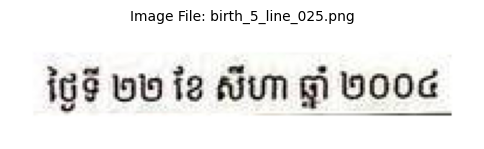

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ថ្ងៃទី ២២ ខែ សីហា ឆ្នាំ ២០០៤
  Tesseract       | ថ្ងៃទី ២២ ខែ សីហា ឆ្នាំ២០០៤ (❌ Fail)
  Custom Model    | ថ្ងៃទី ២២ ខែ សីហា ឆ្នាំ ២០០៤ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


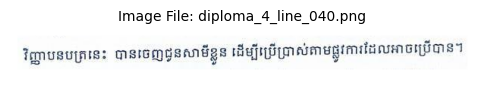

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | វិញ្ញាបនបត្រនេះ បានចេញជូនសាមីខ្លួន ដើម្បីប្រើប្រាស់តាមផ្លូវការដែលអាចប្រើបាន។
  Tesseract       | វិញ្ញាបនបត្រនេះ បានចេញជូនសាមីខ្លួន ដើម្បីប្រើប្រាស់តាមផ្លូវការដែលអាចប្រើបាន៕ (❌ Fail)
  Custom Model    | វិញ្ញាបនបត្រនេះ បានចេញជូនសាមីខ្លួន ដើម្បីប្រើប្រាស់៣មផ្លូវការដែលអាចប្រើជាន។ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


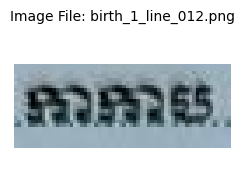

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | កាកាប
  Tesseract       | កាកាប. (❌ Fail)
  Custom Model    | ការកាប (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


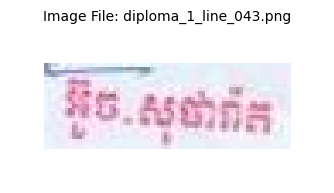

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | អ៊ូច សុផារ៉ាត
  Tesseract       | គួន (❌ Fail)
  Custom Model    | .រួច.សុចរាជំន (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


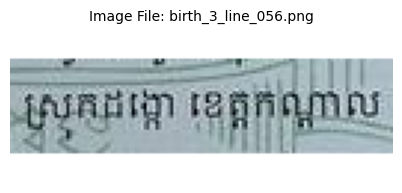

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រុកដង្កោ ខេត្តកណ្តាល
  Tesseract       | មម (❌ Fail)
  Custom Model    | ស្រុកដណ្តោ ខេត្តកណ្តាល (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


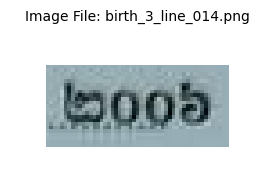

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ២០០៦
  Tesseract       | ២០០៦ / (❌ Fail)
  Custom Model    | ២០០៦ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


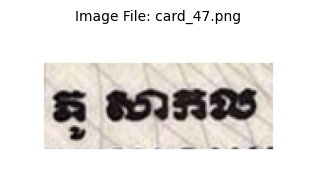

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ភូ សាកល
  Tesseract       | តក (❌ Fail)
  Custom Model    | គូ សាភល (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


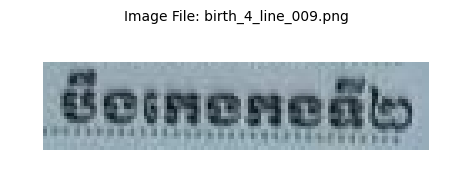

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | បឹងកេងកងទី២
  Tesseract       | ប៊ឺនេកងកងទី២/ (❌ Fail)
  Custom Model    | បឹងភេងកងទី២ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


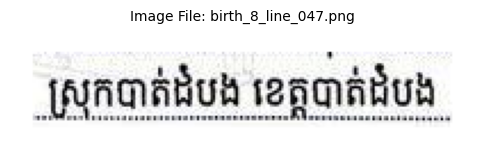

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រុកបាត់ដំបង ខេត្តបាត់ដំបង
  Tesseract       | _ស្រ្តាត់ដំបង ខេត្តបាត់ដំបង (❌ Fail)
  Custom Model    | ស្រុកបាត់ដំបង ខេត្តបាត់ដំបង (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


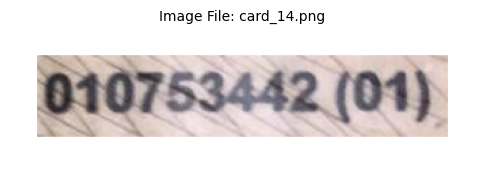

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 010753442 (01)
  Tesseract       | 810753442 (01). (❌ Fail)
  Custom Model    | 01075342 (01) (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


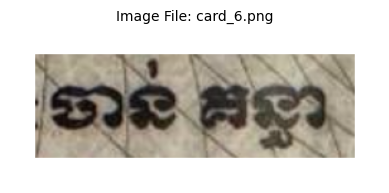

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ចាន់ គន្ឋា
  Tesseract       | ចាន់ គន្ធា (❌ Fail)
  Custom Model    | ចាន់ គន្ធា (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


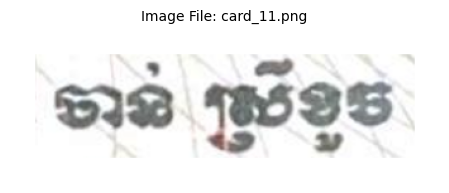

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ចាន់ ស្រីខួច
  Tesseract       | ចាន់ ស្រីខូច (❌ Fail)
  Custom Model    | ចាន់ ស្រឹខួច (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


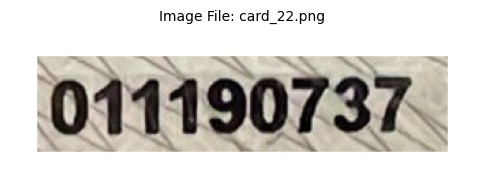

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 011190737
  Tesseract       | 011190737. (❌ Fail)
  Custom Model    | 011190737 (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


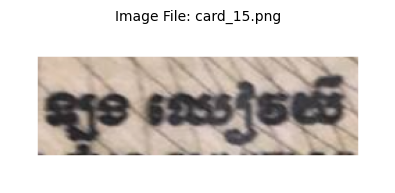

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ឡុង ឈៀវយី
  Tesseract       | | ភទ › ឈៀវរ ន (❌ Fail)
  Custom Model    | ឡូង ឈៀវយឺ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


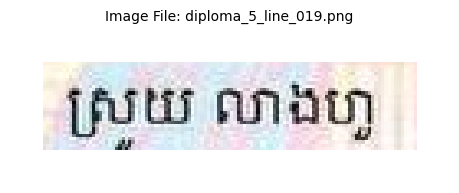

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រួយ លាងហួ
  Tesseract       | ស្រួយ លាងហួ (✅ Match)
  Custom Model    | ស្រយ លាងហួ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


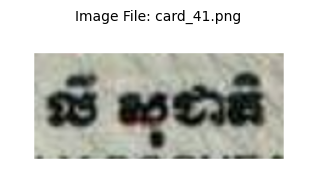

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | លី សុជាតិ
  Tesseract       | លី សុជាតិ. (❌ Fail)
  Custom Model    | លី សុជាតិ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


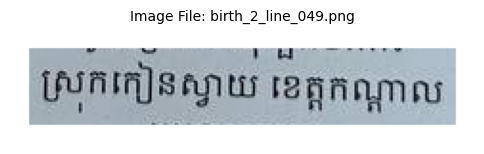

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រុកកៀនស្វាយ ខេត្តកណ្តាល
  Tesseract       | _ហ្រុក្បើនស្វាយ៍ ន៌ត្តកណ្តាល (❌ Fail)
  Custom Model    | ស្រុកកៀនស្វាយ ខេត្តកណ្តាល (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


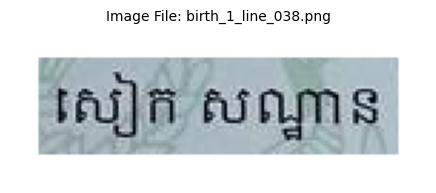

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | សៀក សណ្ឋាន
  Tesseract       | ស្សែក័សណ្ឋីន (❌ Fail)
  Custom Model    | សៀក សណ្ឋាន (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


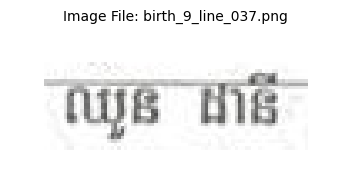

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ឈូន ដានី
  Tesseract       | យឈូន ដានី (❌ Fail)
  Custom Model    | ឈូន ដានី (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


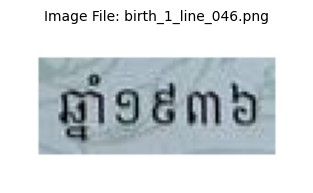

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ឆ្នាំ១៩៣៦
  Tesseract       | _មម័ព័ន (❌ Fail)
  Custom Model    | ឆ្នាំ១៩៣៦ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


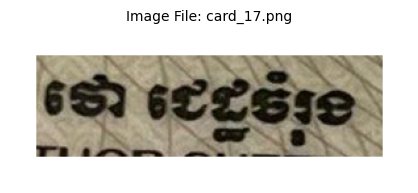

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ថោ ជេដ្ឋចំរុង
  Tesseract       | ថា រជជ្ជម៌រូង (❌ Fail)
  Custom Model    | ថោ ជេដ្ឋទំរុង (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


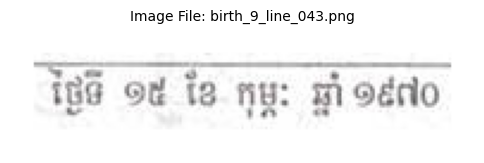

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ថ្ងៃទី ១៥ ខែ កុម្ភៈ ឆ្នាំ១៩៧0
  Tesseract       | ថ្ងៃទី ១៥ ខែ កុម្ភៈ ឆ្នាំ១៩៧0 (✅ Match)
  Custom Model    | ថ្ងៃ0 @៥ ខែ កុម្ភៈ ឆ្នាំ ១៩៧០ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


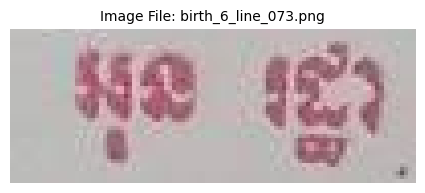

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | អុន រដ្ឋា
  Tesseract       | អុន រដ្ឋា (✅ Match)
  Custom Model    | ។ ។ <unk> <unk> (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


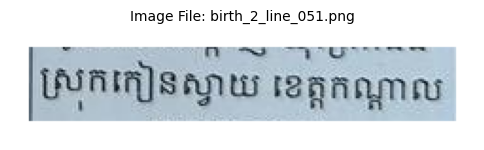

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រុកកៀនស្វាយ ខេត្តកណ្តាល
  Tesseract       | ស្រុកកៀនស្វាយ៍ ខេត្តកណ្តាល (❌ Fail)
  Custom Model    | ស្រុកកៀនស្វាយ ខេត្តកណ្តាល (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


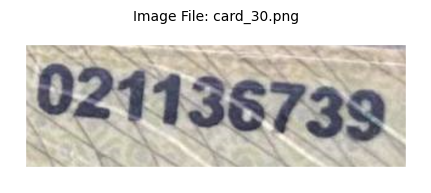

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 021136739
  Tesseract       | 021136739. (❌ Fail)
  Custom Model    | 21136735 (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


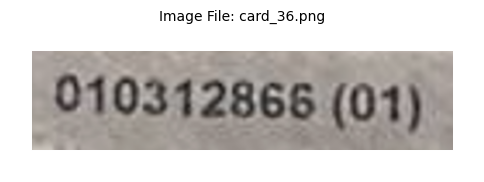

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 010312866 (01)
  Tesseract       | .010312866 (01) / (❌ Fail)
  Custom Model    | 010312866 (01) (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


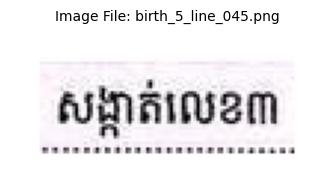

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | សង្កាត់លេខ៣
  Tesseract       | យ (❌ Fail)
  Custom Model    | សង្កាត់លេខ៣ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


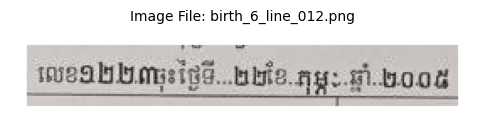

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | លេខ១២២៣ថ្ងៃទី២២ខែ.តុម្ភៈ.ឆ្នាំ.២០០៥
  Tesseract       | យ (❌ Fail)
  Custom Model    | 088១២២៣ :ថ្ងៃទី. ៦២ខែ កុម្ភៈ ឆ្នាំ ២០០៥ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


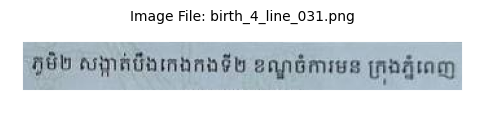

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ភូមិ២ សង្កាត់បឹងកេងកងទី២ ខណ្ឌចំការមន ក្រុងភ្នំពេញ
  Tesseract       | អូម សភ្កាតីម័ងកងកងទ័ម ទណ្ឌទិការមន ក្រុងភ្នំពេញ (❌ Fail)
  Custom Model    | ភូមិ២ សង្កាត់បឹងកេងកឯទី២ ខណ្ឌចំការមន ក្រុងភ្នំពេញ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


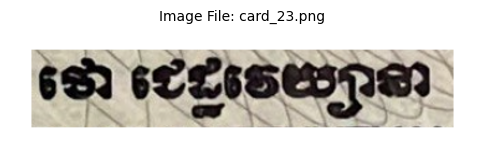

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ថោ ជេដ្ឋវេយ្យានា
  Tesseract       | ថា ជេដ្ឋវវិយ្យាខា (❌ Fail)
  Custom Model    | ថោ ជេដ្ឋរវេយ្យានា (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


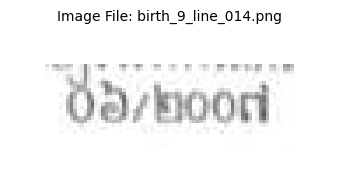

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ០៦/២00៧
  Tesseract       | ៦/២00ព (❌ Fail)
  Custom Model    | ០៦/ 500ព (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


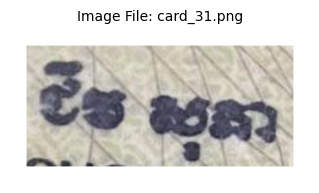

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ជីម សុភា
  Tesseract       | ជីវ សា (❌ Fail)
  Custom Model    | ជីវ ៖ សុគា (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


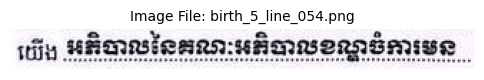

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | យើង អភិបាលនែគណៈអភិបាលខណ្ឌចំការមន
  Tesseract       | យើង .#ភិបាលនៃគណៈអតិបាលខណ្ឌចំការមន. (❌ Fail)
  Custom Model    | យើង .អភិបាលនែកណៈអភិវាណៈអភិវាណ្ណាចិ:ការមន.... (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


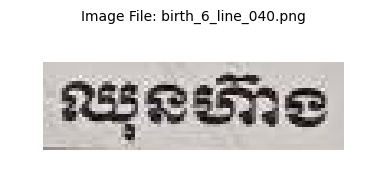

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ឈុនហ៊ាង
  Tesseract       | _ឈុនហ៊ាង (❌ Fail)
  Custom Model    | ឈុនហ៊ាង (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


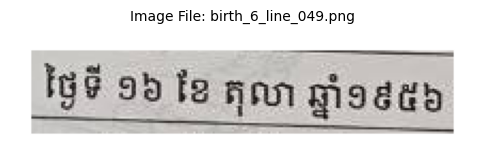

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ថ្ងៃទី ១៦ ខែ តុលា ឆ្នាំ១៩៥៦
  Tesseract       | ថ្ងៃទី ១៦ ខែតុលា ឆ្នាំ១៩៥៦ (❌ Fail)
  Custom Model    | ថ្ងៃទី ១៦ ខែ តុលា ឆ្នាំ១៩៥៦ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


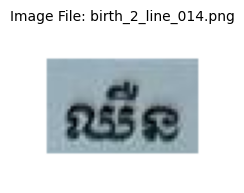

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ឈឺន
  Tesseract       | ឈឺន. (❌ Fail)
  Custom Model    | ឈឺន (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


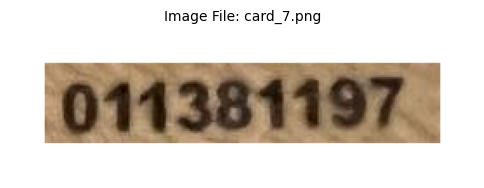

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 011381197
  Tesseract       | ក (❌ Fail)
  Custom Model    | 011381197 (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


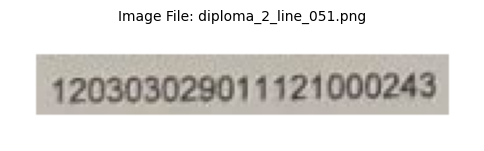

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 120303029011121000243
  Tesseract       | _120303029011121000245 (❌ Fail)
  Custom Model    | 1203030290111121000243 (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


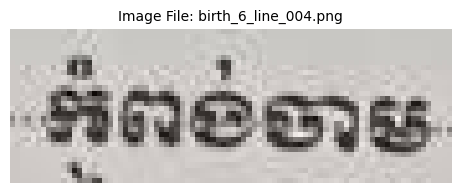

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | កំពង់ចាម
  Tesseract       | កំពង់ចាម. (❌ Fail)
  Custom Model    | ទាំង ចាប់ ម (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


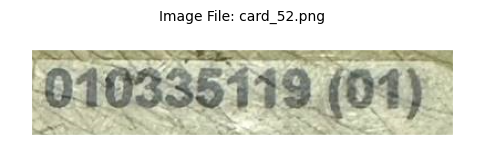

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 010335119 (01)
  Tesseract       |  (❌ Fail)
  Custom Model    | 0103513 (03 ) (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


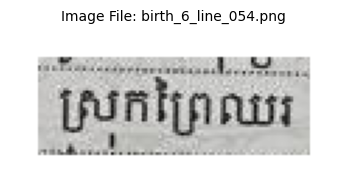

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រុកព្រៃឈរ
  Tesseract       | ស្រុកព្រែឈីរ (❌ Fail)
  Custom Model    | ស្រុកព្រៃឈរ (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


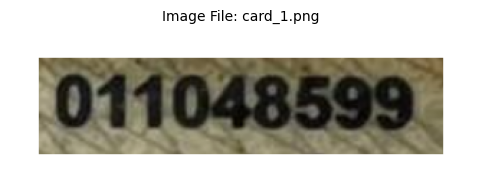

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 011048599
  Tesseract       | 0110អ8569: (❌ Fail)
  Custom Model    | 011048599 (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


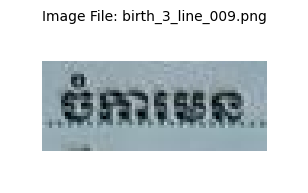

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ចំការមន
  Tesseract       | .បំតារមន (❌ Fail)
  Custom Model    | ចំការមេន (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


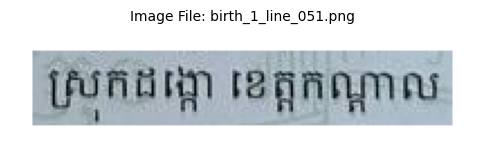

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ស្រុកដង្កោ ខេត្តកណ្តាល
  Tesseract       | _ស្រុក៏ដង្កោ ខេត្ត៍ក៏ណ្តាល / (❌ Fail)
  Custom Model    | ស្រកដង្កោ ខេត្តកណ្តាល (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


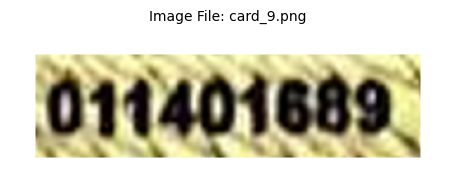

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 011401689
  Tesseract       | 011401689. (❌ Fail)
  Custom Model    | 011401689 (✅ Match)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


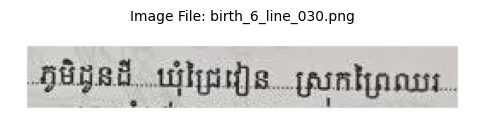

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ភូមិដូនដី ឃុំជ្រៃវៀន ស្រុកព្រៃឈរ
  Tesseract       | .ភូមិដូ នដី,. -ឃុំជ្រៃវៀន .ស្រុកព្រៃឈរ.. (❌ Fail)
  Custom Model    | ភូមិដូនដី. ឃុំជ្រៃវៀន _ស្រុកព្រៃឈរ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


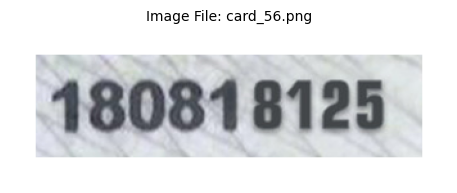

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | 180818125
  Tesseract       | 180818125 (✅ Match)
  Custom Model    | 18081 8125 (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


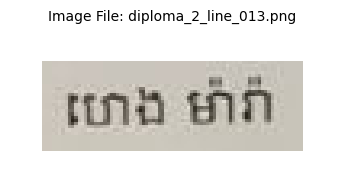

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ហេង ម៉ារ៉ា
  Tesseract       | _ហេងម៉ារ៉ (❌ Fail)
  Custom Model    | ហេង ម៉ាវ៉ា (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


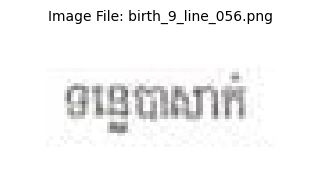

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ទន្លេបាសាក់
  Tesseract       | ទន្លេបាសាក់. (❌ Fail)
  Custom Model    | ទន្ទេបាលាក់ (❌ Fail)
------------------------------------------------------------



/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


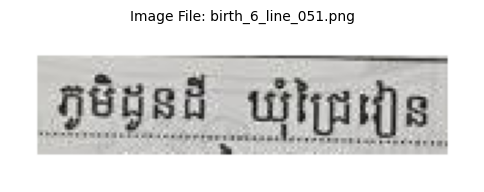

  Type            | Text Content
--------------------------------------------------
  Ground Truth    | ភូមិដូនដី  ឃុំជ្រៃវៀន
  Tesseract       | ភូមិដូនដី . ឃុំជ្រៃវៀន (❌ Fail)
  Custom Model    | ភូមិដូនដី _ ឃុំជ្រៃវៀន (❌ Fail)
------------------------------------------------------------



In [15]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import torch

# ==========================================
# 1. Configuration
# ==========================================

# Path to the data subset (e.g., khob_eval)
DATASET_PATH = "/content/drive/MyDrive/CNN-Transformer-OCR/test_set/legal_documents"

# Path to your Custom Model Checkpoint
MODEL_PATH = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth"

# Number of examples to show
NUM_EXAMPLES = 50

# Tesseract Config
TESS_LANG = 'khm'
TESS_CONFIG = '--psm 7'

# ==========================================
# 2. Comparison Logic
# ==========================================

def get_styled_text(text, is_correct):
    """Returns text colored Green (correct) or Red (incorrect) for console print."""
    GREEN = "\033[92m"
    RED = "\033[91m"
    RESET = "\033[0m"
    if is_correct:
        return f"{GREEN}{text} (✅ Match){RESET}"
    else:
        return f"{RED}{text} (❌ Fail){RESET}"

def visualize_failures(dataset_path, custom_model, num_to_show=5):
    img_dir = os.path.join(dataset_path, "images")
    lbl_dir = os.path.join(dataset_path, "labels")

    # Get list of images
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    random.shuffle(files) # Shuffle to see different ones every time

    shown_count = 0

    print(f"🚀 Scanning for 'Interesting Cases' (Disagreements or Failures)...")
    print("-" * 60)

    for fname in files:
        if shown_count >= num_to_show:
            break

        # 1. Load Data
        img_path = os.path.join(img_dir, fname)
        lbl_path = os.path.join(lbl_dir, os.path.splitext(fname)[0] + ".txt")

        if not os.path.exists(lbl_path):
            continue

        with open(lbl_path, "r", encoding="utf-8") as f:
            gt_text = f.read().strip()

        # 2. Get Predictions
        try:
            # Tesseract
            img_pil = Image.open(img_path).convert("RGB")
            tess_pred = pytesseract.image_to_string(img_pil, lang=TESS_LANG, config=TESS_CONFIG).strip()

            # Custom Model
            custom_pred = custom_model.predict(img_path, beam_width=5)

        except Exception as e:
            print(f"Error processing {fname}: {e}")
            continue

        # 3. Filter: Only show if at least one model is wrong (to make it interesting)
        # If both are perfect, we skip (unless you want to see those too)
        if (tess_pred == gt_text) and (custom_pred == gt_text):
            continue

        # 4. Visualize
        shown_count += 1

        # Plot Image
        plt.figure(figsize=(6, 2))
        plt.imshow(img_pil)
        plt.axis('off')
        plt.title(f"Image File: {fname}", fontsize=10)
        plt.show()

        # Print Comparison Table
        print(f"  {'Type':<15} | {'Text Content'}")
        print("-" * 50)
        print(f"  {'Ground Truth':<15} | {gt_text}")
        print(f"  {'Tesseract':<15} | {get_styled_text(tess_pred, tess_pred == gt_text)}")
        print(f"  {'Custom Model':<15} | {get_styled_text(custom_pred, custom_pred == gt_text)}")
        print("-" * 60 + "\n")

# ==========================================
# 3. Run
# ==========================================

if __name__ == "__main__":
    try:
        # 1. Initialize Custom Model
        # Assuming 'char2idx' is available in your global scope from previous cells
        # If not, you need to load your vocab json here
        ocr_engine = KhmerOCRInference(MODEL_PATH, char2idx)

        # 2. Run Visualization
        visualize_failures(DATASET_PATH, ocr_engine, NUM_EXAMPLES)

    except NameError:
        print("❌ Error: 'KhmerOCRInference' or 'char2idx' not defined.")

In [18]:
# @title
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import json
import math

# ==========================================
# 1. Helper Functions
# ==========================================

def chunk_image_inference(img_tensor, chunk_width=100, overlap=16):
    """
    Splits image into chunks. Matches training logic.
    """
    C, H, W = img_tensor.shape
    chunks = []
    start = 0

    while start < W:
        end = min(start + chunk_width, W)
        chunk = img_tensor[:, :, start:end]

        # Pad last chunk if shorter than chunk_width (Pad with 1.0 = White)
        if chunk.shape[2] < chunk_width:
            pad_size = chunk_width - chunk.shape[2]
            # F.pad: (left, right, top, bottom)
            chunk = F.pad(chunk, (0, pad_size, 0, 0), value=1.0)

        chunks.append(chunk)
        start += chunk_width - overlap

    return chunks

# ==========================================
# 2. Inference Class (Beam Search Enabled)
# ==========================================

class KhmerOCRInference:
    def __init__(self, model_path, char2idx_input, device='cuda'):
        """
        model_path: Path to .pt file
        char2idx_input: Dictionary OR Path to .json file
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # 1. Load Vocabulary
        if isinstance(char2idx_input, dict):
            self.char2idx = char2idx_input
        elif isinstance(char2idx_input, str):
            with open(char2idx_input, 'r', encoding='utf-8') as f:
                self.char2idx = json.load(f)
        else:
            raise ValueError("char2idx_input must be a dictionary or a json file path.")

        self.idx2char = {v: k for k, v in self.char2idx.items()}
        self.sos_idx = self.char2idx.get("<sos>")
        self.eos_idx = self.char2idx.get("<eos>")
        self.pad_idx = self.char2idx.get("<pad>", 0)

        if self.sos_idx is None or self.eos_idx is None:
            raise ValueError("Vocabulary must contain <sos> and <eos>")

        # 2. Initialize Model
        # Ensure these params match your training!
        self.model = KhmerOCR(
            vocab_size=len(self.char2idx),
            pad_idx=self.pad_idx,
            emb_dim=384,
            max_global_len=4096
        )

        # 3. Load Weights
        print(f"Loading weights from {model_path}...")
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint)
        self.model.to(self.device)
        self.model.eval()

        # 4. Transform
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(), # 0..1
        ])

    def preprocess(self, image_path):
        """
        Loads, RESIZES to Height 48, Chunks, and Normalizes.
        """
        # Load directly as Grayscale
        image = Image.open(image_path).convert('L')

        # --- CRITICAL FIX: RESIZE TO HEIGHT 48 ---
        target_height = 48
        aspect_ratio = image.width / image.height
        new_width = int(target_height * aspect_ratio)
        image = image.resize((new_width, target_height), Image.Resampling.BILINEAR)
        # -----------------------------------------

        img_tensor = self.transform(image) # [1, 48, W]

        # Chunking
        chunks = chunk_image_inference(img_tensor, chunk_width=100, overlap=16)

        # Normalization (Matches training: (x-0.5)/0.5)
        chunks_norm = [(c - 0.5) / 0.5 for c in chunks]

        # Stack to tensor [N_Chunks, 1, 48, 100]
        return torch.stack(chunks_norm).to(self.device)

    def encode_image(self, chunks_tensor):
        """
        Runs the CNN + Transformer Encoder + Merger + Global Pos
        Returns: memory [1, SeqLen, Dim]
        """
        # chunks_tensor: [N, 1, 48, 100]

        with torch.no_grad():
            # 1. CNN
            f = self.model.cnn(chunks_tensor) # [N, 512, 2, 32]

            # 2. Patch Embedding
            p, _ = self.model.patch(f) # [N, 32, 384]

            # 3. Transformer Encoder (Independent Chunks)
            # Input: [Seq, Batch, Dim]
            p = p.transpose(0, 1).contiguous()
            enc_out = self.model.enc(p)
            enc_out = enc_out.transpose(0, 1) # [N, 32, 384]

            # 4. Merger (Flatten N chunks into 1 sequence)
            # enc_out: [N, 32, Dim] -> [1, N*32, Dim]
            N, L, D = enc_out.shape
            merged_seq = enc_out.reshape(1, N * L, D)
            memory = merged_seq

            # 5. Global Positional Embedding
            B, T, _ = memory.shape
            limit = min(T, self.model.global_pos.size(0))
            pos_emb = self.model.global_pos[:limit, :].unsqueeze(0)

            if T > self.model.global_pos.size(0):
                 memory = memory[:, :limit, :] + pos_emb
            else:
                 memory = memory + pos_emb

            return memory

    def predict(self, image_path, max_len=128, beam_width=3):
        """
        Main inference method.
        beam_width=1 -> Greedy Search
        beam_width>1 -> Beam Search
        """
        # 1. Preprocess
        chunks_tensor = self.preprocess(image_path)

        # 2. Encode (Once)
        memory = self.encode_image(chunks_tensor)

        # 3. Decode
        if beam_width <= 1:
            tokens = self._greedy_decode(memory, max_len)
        else:
            tokens = self._beam_search(memory, max_len, beam_width)

        # 4. Detokenize
        result_text = ""
        for idx in tokens:
            if idx == self.sos_idx or idx == self.pad_idx:
                continue
            if idx == self.eos_idx:
                break
            char = self.idx2char.get(idx, "")
            result_text += char

        return result_text

    def _greedy_decode(self, memory, max_len):
        B, T, _ = memory.shape
        # Mask is all False (valid) because inference has no padding
        memory_mask = torch.zeros((B, T), dtype=torch.bool, device=self.device)

        generated = [self.sos_idx]

        with torch.no_grad():
            for _ in range(max_len):
                tgt = torch.LongTensor([generated]).to(self.device)
                logits = self.model.dec(tgt, memory, memory_mask)
                next_token = torch.argmax(logits[0, -1, :]).item()

                if next_token == self.eos_idx:
                    break
                generated.append(next_token)
        return generated

    def _beam_search(self, memory, max_len, beam_width):
        """
        Batched Beam Search Implementation
        """
        B, T, D = memory.shape

        # 1. Expand Memory to match beam width
        # memory: [1, T, D] -> [K, T, D]
        memory = memory.expand(beam_width, -1, -1)
        memory_mask = torch.zeros((beam_width, T), dtype=torch.bool, device=self.device)

        # 2. Initialize Beams
        # Format: (score, [sequence])
        # We start with 1 beam, but we treat it as K identical ones initially to simplify batching
        # or just run 1 item in the first step. Let's do standard expansion.
        beams = [(0.0, [self.sos_idx])]

        completed_beams = []

        with torch.no_grad():
            for step in range(max_len):
                # Prepare batch of inputs
                # Filter out finished beams? No, we filter at the end of the step.
                k_curr = len(beams)

                # Construct input tensor [k_curr, SeqLen]
                # We need to pad sequences if they differ in length (unlikely in standard beam search, but good practice)
                # Here they are always same length per step.
                current_seqs = [b[1] for b in beams]
                tgt = torch.tensor(current_seqs, dtype=torch.long, device=self.device)

                # Run Decoder on batch
                # Use slice of memory corresponding to k_curr
                step_logits = self.model.dec(tgt, memory[:k_curr], memory_mask[:k_curr])

                # Get Log Probs of the last token
                # shape: [k_curr, Vocab]
                last_token_logits = step_logits[:, -1, :]
                log_probs = F.log_softmax(last_token_logits, dim=-1)

                # Generate Candidates
                candidates = []
                for i in range(k_curr):
                    score_so_far = beams[i][0]
                    seq_so_far = beams[i][1]

                    # Optimization: Only consider top K tokens to reduce sorting overhead
                    topk_probs, topk_idx = log_probs[i].topk(beam_width)

                    for k in range(beam_width):
                        token = topk_idx[k].item()
                        prob = topk_probs[k].item()

                        new_score = score_so_far + prob
                        new_seq = seq_so_far + [token]
                        candidates.append((new_score, new_seq))

                # Sort and Select Top K
                candidates.sort(key=lambda x: x[0], reverse=True)

                next_beams = []
                for score, seq in candidates:
                    if seq[-1] == self.eos_idx:
                        # Normalize score by length to be fair
                        norm_score = score / (len(seq) - 1)
                        completed_beams.append((norm_score, seq))
                    else:
                        next_beams.append((score, seq))
                        if len(next_beams) == beam_width:
                            break

                beams = next_beams

                # Stop if no active beams left
                if not beams:
                    break

        # Final Selection
        if completed_beams:
            completed_beams.sort(key=lambda x: x[0], reverse=True)
            return completed_beams[0][1]
        elif beams:
            return beams[0][1] # Return best partial
        else:
            return [self.sos_idx]

# ==========================================
# 3. Usage Example
# ==========================================

if __name__ == "__main__":
    # 1. Settings
    MODEL_FILE = "/content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth" # Update epoch

    # Assuming 'char2idx' dictionary exists in your notebook variables
    # If not, load it from a file
    VOCAB_DATA = char2idx

    IMAGE_FILE = "/content/card_1.png"

    try:
        # 2. Init
        ocr = KhmerOCRInference(MODEL_FILE, VOCAB_DATA)

        print(f"Processing: {IMAGE_FILE}")

        # 3. Predict with Beam Search (Width 3 or 5 is standard)
        text = ocr.predict(IMAGE_FILE, beam_width=3)

        print("\n" + "="*30)
        print(f"RESULT: {text}")
        print("="*30 + "\n")

    except FileNotFoundError:
        print("Error: Check your model or image path.")
    except Exception as e:
        import traceback
        traceback.print_exc()

Loading weights from /content/drive/MyDrive/CNN-Transformer-OCR/checkpoints/khmerocr_epoch100.pth...
Processing: /content/card_1.png

RESULT: 011048599



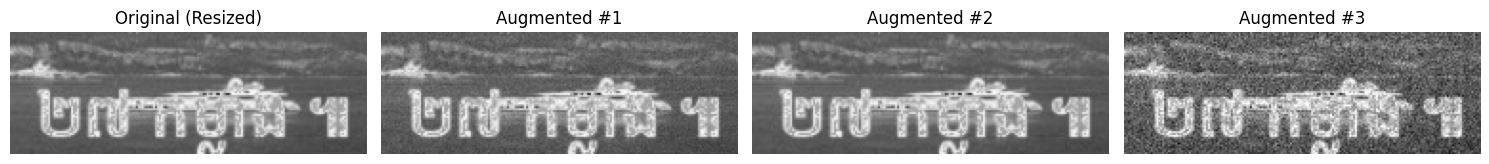

In [ ]:
# @title
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. YOUR AUGMENTER CLASS
# ============================================================

class ConsistentAugmenter:
    def __init__(self, augment_prob=0.8, is_low_res_input=True):
        self.augment_prob = augment_prob
        self.is_low_res = is_low_res_input
        self.pad_value = 1.0 # White background

    def __call__(self, img):
        # 1. Decide if we augment this specific image
        if random.random() > self.augment_prob:
            return img

        C, H, W = img.shape

        # --- Random Decisions (Must be calculated PER IMAGE) ---
        geom_mode = random.choice(['none', 'short', 'shrink'])
        scale_h = random.uniform(0.7, 0.98)
        scale_all = random.uniform(0.8, 0.98)

        do_pixelate = False
        if not self.is_low_res:
            do_pixelate = random.random() < 0.5

        do_blur = random.random() < 0.3
        blur_sigma = random.uniform(0.5, 1.0) if self.is_low_res else random.uniform(1.0, 2.0)

        do_noise = random.random() < 0.5
        noise_std = random.uniform(0.02, 0.08)

        do_shift = random.random() < 0.5
        shift_x = random.randint(-8, 8)

        do_erode = False
        if not self.is_low_res:
            do_erode = random.random() < 0.2

        # --- EXECUTE AUGMENTATIONS ---

        # 1. Geometry
        if geom_mode == 'short':
            new_h = int(H * scale_h)
            if new_h < H:
                resized = F.interpolate(img.unsqueeze(0), size=(new_h, W), mode='bilinear', align_corners=False).squeeze(0)
                background = torch.full_like(img, self.pad_value)
                pad_top = (H - new_h) // 2
                background[:, pad_top : pad_top + new_h, :] = resized
                img = background

        elif geom_mode == 'shrink':
            new_h = int(H * scale_all)
            new_w = int(W * scale_all)
            new_w = max(1, new_w)
            if new_h < H:
                resized = F.interpolate(img.unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False).squeeze(0)
                background = torch.full_like(img, self.pad_value)
                pad_top = (H - new_h) // 2
                pad_left = (W - new_w) // 2
                # Ensure dimensions match before assigning
                end_y = pad_top + new_h
                end_x = pad_left + new_w
                if end_y <= H and end_x <= W:
                    background[:, pad_top:end_y, pad_left:end_x] = resized
                    img = background

        # 2. Pixelate
        if do_pixelate:
            pixelate_scale = random.uniform(0.4, 0.7)
            small_h = int(H * pixelate_scale)
            small_w = int(W * pixelate_scale)
            small_h, small_w = max(16, small_h), max(4, small_w)
            small = F.interpolate(img.unsqueeze(0), size=(small_h, small_w), mode='bilinear', align_corners=False)
            img = F.interpolate(small, size=(H, W), mode='bilinear', align_corners=False).squeeze(0)

        # 3. Erosion (Thinning text on white background)
        if do_erode:
            erode_k = 3
            padding = erode_k // 2
            # Max pooling on (0=Black, 1=White) expands White -> Erodes Black text
            fully_eroded = F.max_pool2d(img, kernel_size=erode_k, stride=1, padding=padding)
            img = torch.lerp(img, fully_eroded, random.uniform(0.5, 0.8))

        # 4. Blur
        if do_blur:
            img = self.gaussian_blur(img, 3, blur_sigma)

        # 5. Noise
        if do_noise:
            noise = torch.randn_like(img) * noise_std
            img = torch.clamp(img + noise, 0.0, 1.0)

        # 6. Shift
        if do_shift and shift_x != 0:
            shifted = torch.full_like(img, self.pad_value)
            if shift_x > 0: # Shift Right
                if shift_x < W:
                    shifted[:, :, shift_x:] = img[:, :, :-shift_x]
            else: # Shift Left
                abs_x = abs(shift_x)
                if abs_x < W:
                    shifted[:, :, :-abs_x] = img[:, :, abs_x:]
            img = shifted

        return img

    def gaussian_blur(self, img, kernel_size, sigma):
        x = torch.arange(kernel_size, dtype=torch.float32, device=img.device) - kernel_size // 2
        kernel_1d = torch.exp(-x**2 / (2 * sigma**2))
        kernel_1d = kernel_1d / kernel_1d.sum()
        k_x = kernel_1d.view(1, 1, 1, kernel_size)
        k_y = kernel_1d.view(1, 1, kernel_size, 1)
        pad = kernel_size // 2
        img = F.conv2d(img.unsqueeze(0), k_x, padding=(0, pad), groups=img.shape[0])
        img = F.conv2d(img, k_y, padding=(pad, 0), groups=img.shape[0])
        return img.squeeze(0)

# ============================================================
# 2. VISUALIZATION CODE
# ============================================================

def plot_augmentation(image_path, num_samples=3):
    """
    Loads an image, applies the augmenter, and plots the results.
    """
    try:
        # 1. Load Image & Preprocess
        # We use Grayscale ('L') because your augmenter assumes single channel processing logic often
        # (though it handles C channels, text OCR is usually grayscale)
        pil_img = Image.open(image_path).convert('L')

        # Resize to a typical OCR height (e.g., 48 or 64) to make the effects realistic
        target_height = 64
        aspect_ratio = pil_img.width / pil_img.height
        target_width = int(target_height * aspect_ratio)
        pil_img = pil_img.resize((target_width, target_height), Image.Resampling.BILINEAR)

        # Convert to Tensor (Values 0.0 to 1.0)
        transform = transforms.ToTensor()
        img_tensor = transform(pil_img)

        # 2. Initialize Augmenter
        # Set prob=1.0 so we ALWAYS see an effect for the demo
        augmenter = ConsistentAugmenter(augment_prob=1.0, is_low_res_input=True)

        # 3. Generate Augmented Versions
        augmented_imgs = []
        for _ in range(num_samples):
            # Clone tensor so we don't modify the original in place
            aug_result = augmenter(img_tensor.clone())
            augmented_imgs.append(aug_result)

        # 4. Plotting
        fig, axes = plt.subplots(1, num_samples + 1, figsize=(15, 5))

        # Plot Original
        axes[0].imshow(img_tensor.permute(1, 2, 0).numpy(), cmap='gray', vmin=0, vmax=1)
        axes[0].set_title("Original (Resized)")
        axes[0].axis('off')

        # Plot Augmentations
        for i, aug_img in enumerate(augmented_imgs):
            # Permute (C, H, W) -> (H, W, C) for Matplotlib
            axes[i+1].imshow(aug_img.permute(1, 2, 0).numpy(), cmap='gray', vmin=0, vmax=1)
            axes[i+1].set_title(f"Augmented #{i+1}")
            axes[i+1].axis('off')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: Could not find image at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# ============================================================
# 3. RUN EXAMPLE
# ============================================================

# Replace 'path/to/your/image.png' with a real file path
# If you are in Colab, you can upload an image and use its name
image_path = "/content/khmer_000079.jpeg"

# Create a dummy image if you don't have one, just to make the code runnable immediately
if not os.path.exists(image_path):
    import os
    print("Creating a dummy image for demonstration...")
    # Create a white image with some black text-like lines
    dummy = Image.new('L', (200, 64), color=255)
    from PIL import ImageDraw
    draw = ImageDraw.Draw(dummy)
    draw.text((10, 20), "Hello World", fill=0) # Need a font, but default is fine
    # Draw simple lines to simulate text if no font
    for i in range(10, 180, 20):
        draw.rectangle([i, 20, i+10, 40], fill=0)
    dummy.save(image_path)

# Run the visualizer
plot_augmentation(image_path, num_samples=3)